# 5PM - ShopeeFood Analysis

**Proposal Question**: "Do factors such as price, working time, location, menu,... affect the success of a restaurant in the Ho Chi Minh City area?"

**Table of Content**:
* I. Preparation
* II. EDA & Preprocessing
* III. Models Building
* IV. Conclusion
* V. Extra Testing
* VI. After Presentation

(Conclusion in the section IV)

**Proposal Question**: "Do factors such as price, working time, location, menu,... affect the success of a restaurant in the Ho Chi Minh City area?"

**Answer**: No. Those factors have ***no/very little effect*** on the success of a restaurant.

**Why**:

* The models are prone to be easily overfitted. We tracked the performance of all models when tuning the hyperparameters and realized that: the `train accuracy score` can be really high, but the `test accuracy score` keeps fluctuating around a constant not-high number (0.6 - 0.7).
* The `F1-score` (and `precision`, `recall`) of the label "Good" (minority class) is very low. We tested some sampling method to balance the dataset and track the performance of models: `F1-score` increased (not much), but this is a trade-off, because the `accuracy score` (not high already) decreased. (Every test that we try to balance the dataset will lead to this trade-off)

**The trade-off**:

* An unbalanced classification model has high `accuracy score` (around 0.8), but low `F1-score` (around 0.2) means that: it only need to predict all the samples as the majority class (in this situation, the "Bad" label), and it will have high accuracy.
* A re-balanced classification model (with sampling data) has not-high `accuracy score` (around 0.6) and not-high `F1-score` (around 0.5) is still bad. 0.6 accuracy (near 0.5) is too similar to take the result of tossing a coin.

# I. Preparation

## 1. Import libraries

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
sns.set_theme(style="whitegrid")
pd.options.mode.chained_assignment = None  # default='warn'

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics

In [ ]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
# Random Forest
from sklearn.ensemble import RandomForestClassifier
# XGBoost
import xgboost
from xgboost import XGBClassifier

## 2. Import dataset

In [ ]:
!git clone https://github.com/baobuiquang/datasets.git

Cloning into 'datasets'...
remote: Enumerating objects: 155, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 155 (delta 8), reused 42 (delta 2), pack-reused 107
Receiving objects: 100% (155/155), 337.04 MiB | 15.81 MiB/s, done.
Resolving deltas: 100% (40/40), done.
Checking out files: 100% (49/49), done.


In [ ]:
df_0 = pd.DataFrame(pd.read_excel('/content/datasets/CSC17107/shopee_3rd.xlsx'))
df_0

Source Location_url  \
0      shopee_bonuss.xlsx  ho-chi-minh   
1      shopee_bonuss.xlsx  ho-chi-minh   
2      shopee_bonuss.xlsx  ho-chi-minh   
3      shopee_bonuss.xlsx  ho-chi-minh   
4      shopee_bonuss.xlsx  ho-chi-minh   
...                   ...          ...   
83346       20222012.xlsx  ho-chi-minh   
83347       20222012.xlsx  ho-chi-minh   
83348       20222012.xlsx  ho-chi-minh   
83349       20222012.xlsx  ho-chi-minh   
83350       20222012.xlsx  ho-chi-minh   

                                                Name_Res         Categories  \
0      Royaltea - Nguyên Liệu Trà Sữa Đóng Gói - Tây ...  ['Shop/Cửa hàng']   
1      Royaltea - Nguyên Liệu Trà Sữa Đóng Gói - Lê T...  ['Shop/Cửa hàng']   
2      Royaltea - Nguyên Liệu Trà Sữa Đóng Gói - Lũy ...  ['Shop/Cửa hàng']   
3      Royaltea - Nguyên Liệu Trà Sữa Đóng Gói - Trươ...  ['Shop/Cửa hàng']   
4      Royaltea - Nguyên Liệu Trà Sữa Đóng Gói - Trịn...  ['Shop/Cửa hàng']   
...                                                  ...                ...   
83346                      Hai Anh Em - Bánh Canh Chả Cá        ['Quán ăn']   
83347                               Cơm Gà 110 - Ba Đình        ['Quán ăn']   
83348                         Hủ Tiếu Hoa - Trần Đình Xu        ['Quán ăn']   
83349  3 Râu - Gà Rán, Pizza, Trà Sữa & Xiên Que - Qu...        ['Quán ăn']   
83350                            Chú Tèo - Cơm Gà Xối Mỡ        ['Quán ăn']   

           Cuisines Short_description  is_open  \
0               NaN               NaN      1.0   
1               NaN               NaN      1.0   
2               NaN               NaN      1.0   
3               NaN               NaN      1.0   
4               NaN               NaN      1.0   
...             ...               ...      ...   
83346  ['Món Việt']              None      0.0   
83347  ['Món Việt']              None      0.0   
83348  ['Món Việt']              None      0.0   
83349  ['Món Việt']              None      0.0   
83350  ['Món Việt']              None      0.0   

                                        url_rewrite_name  \
0        royaltea-nguyen-lieu-tra-sua-dong-goi-tay-thanh   
1      royaltea-nguyen-lieu-tra-sua-dong-goi-le-trong...   
2      royaltea-nguyen-lieu-tra-sua-dong-goi-luy-ban-...   
3      royaltea-nguyen-lieu-tra-sua-dong-goi-truong-v...   
4      royaltea-nguyen-lieu-tra-sua-dong-goi-trinh-di...   
...                                                  ...   
83346                        hai-anh-em-banh-canh-cha-ca   
83347                                 com-ga-110-ba-dinh   
83348                           hu-tieu-hoa-tran-dinh-xu   
83349                         3-rau-ga-ran-pizza-tra-sua   
83350                              chu-teo-com-ga-xoi-mo   

       total_review_shopee_food  has_contract  ...  location_rating  \
0                           0.0           1.0  ...              NaN   
1                           0.0           1.0  ...              NaN   
2                           0.0           1.0  ...              NaN   
3                           0.0           1.0  ...              NaN   
4                           0.0           1.0  ...              NaN   
...                         ...           ...  ...              ...   
83346                     100.0           1.0  ...              9.0   
83347                    1000.0           1.0  ...              3.0   
83348                    1000.0           1.0  ...              7.7   
83349                    1000.0           1.0  ...              7.8   
83350                      10.0           1.0  ...             10.0   

      price_rating  quality_rating  service_rating space_rating  \
0              NaN             NaN             NaN          NaN   
1              NaN             NaN             NaN          NaN   
2              NaN             NaN             NaN          NaN   
3              NaN             NaN             NaN          NaN   
4              NaN             NaN             NaN     

In [ ]:
df = df_0.copy()

## Some functions

In [ ]:
import string
# A simple function to find nth occurence in a string
def find_nth(haystack, needle, n):
    start = haystack.find(needle)
    while start >= 0 and n > 1:
        start = haystack.find(needle, start+1)
        n -= 1
    return start

# II. EDA & Preprocessing

## 1. Basic information about the dataset

In [ ]:
# Basic information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83351 entries, 0 to 83350
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Source                    83351 non-null  object 
 1   Location_url              83351 non-null  object 
 2   Name_Res                  82933 non-null  object 
 3   Categories                82933 non-null  object 
 4   Cuisines                  54234 non-null  object 
 5   Short_description         44120 non-null  object 
 6   is_open                   82933 non-null  float64
 7   url_rewrite_name          82933 non-null  object 
 8   total_review_shopee_food  82933 non-null  float64
 9   has_contract              82933 non-null  float64
 10  avg_point                 82933 non-null  float64
 11  address                   82933 non-null  object 
 12  min_price                 82933 non-null  float64
 13  max_price                 82933 non-null  float64
 14  minimu

In [ ]:
# Know the datatypes
df.dtypes

Source                       object
Location_url                 object
Name_Res                     object
Categories                   object
Cuisines                     object
Short_description            object
is_open                     float64
url_rewrite_name             object
total_review_shopee_food    float64
has_contract                float64
avg_point                   float64
address                      object
min_price                   float64
max_price                   float64
minimum_shipping_fee         object
lattitude                   float64
longitude                   float64
location_rating             float64
price_rating                float64
quality_rating              float64
service_rating              float64
space_rating                float64
working_hour                 object
avg_rating                  float64
District                     object
Menu                         object
Geocode                      object
dtype: object

In [ ]:
# Descriptive statistics
df.describe()

is_open  total_review_shopee_food  has_contract     avg_point  \
count  82933.000000              82933.000000  82933.000000  82933.000000   
mean       0.451147                 94.599870      0.811173      3.279993   
std        0.497611                243.716978      0.391374      2.147398   
min        0.000000                  0.000000      0.000000      0.000000   
25%        0.000000                  0.000000      1.000000      0.000000   
50%        0.000000                  8.000000      1.000000      4.600000   
75%        1.000000                 50.000000      1.000000      4.800000   
max        1.000000               1000.000000      1.000000      5.000000   

          min_price     max_price     lattitude     longitude  \
count  8.293300e+04  8.293300e+04  82933.000000  82933.000000   
mean   2.290675e+04  1.154427e+05     10.789151    106.670331   
std    3.474734e+04  3.393964e+05      0.079050      0.898563   
min    0.000000e+00  0.000000e+00      0.725106      6.605705   
25%    1.000000e+04  2.400000e+04     10.761224    106.647051   
50%    1.500000e+04  4.500000e+04     10.788903    106.678294   
75%    3.000000e+04  1.000000e+05     10.812473    106.703499   
max    2.500010e+06  2.000000e+07     11.320184    106.987940   

       location_rating  price_rating  quality_rating  service_rating  \
count     21944.000000  21944.000000    21944.000000    21944.000000   
mean          7.328509      7.613147        7.888297        6.941287   
std           1.944633      1.888961        1.840821        1.992759   
min           0.900000      0.900000        1.000000        0.800000   
25%           6.500000      6.800000        7.000000        6.000000   
50%           7.500000      7.800000        8.000000        7.000000   
75%           8.700000      9.000000        9.300000        8.000000   
max          10.000000     10.000000       10.000000       10.000000   

       space_rating    avg_rating  
count  21944.000000  82923.000000  
mean       6.439952      1.916193  
std        2.033657      3.334994  
min        0.300000      0.000000  
25%        5.500000      0.000000  
50%        6.600000      0.000000  
75%        7.700000      3.800000  
max       10.000000     10.000000

## 2. Preprocessing

### 2.1. Drop unnecessary columns

In [ ]:
df.drop(columns=[
  'Source',
  'Location_url',
  'Short_description',
  'is_open',
  'url_rewrite_name',
  'lattitude',
  'longitude',
  'Geocode',
], inplace=True)

### 2.2. Remove duplicated rows

In [ ]:
# Find the duplicates if any
df.duplicated().sum()

14608

In [ ]:
# Remove the duplicates
df.drop_duplicates(inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68743 entries, 0 to 83350
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Name_Res                  68742 non-null  object 
 1   Categories                68742 non-null  object 
 2   Cuisines                  48050 non-null  object 
 3   total_review_shopee_food  68742 non-null  float64
 4   has_contract              68742 non-null  float64
 5   avg_point                 68742 non-null  float64
 6   address                   68742 non-null  object 
 7   min_price                 68742 non-null  float64
 8   max_price                 68742 non-null  float64
 9   minimum_shipping_fee      68742 non-null  object 
 10  location_rating           18975 non-null  float64
 11  price_rating              18975 non-null  float64
 12  quality_rating            18975 non-null  float64
 13  service_rating            18975 non-null  float64
 14  space_

### 2.3. Preprocess some numerical columns

#### Column `avg_rating`

In [ ]:
df['avg_rating'].unique()

array([ 0. ,  nan,  7.4,  6.5,  1.2,  7.1,  9.4, 10. ,  7.6,  7.7,  6.9,
        8.4,  5.6,  4.2,  9.2,  9.7,  3.9,  9.3,  5. ,  8. ,  4.3,  8.6,
        8.1,  5.4,  8.7,  1. ,  6.3,  8.9,  5.7,  6.6,  6. ,  8.8,  7.5,
        7.3,  6.8,  7.2,  7.8,  6.7,  7.9,  4.7,  9.8,  3.4,  9. ,  5.8,
        7. ,  2.6,  8.2,  4.8,  3.3,  6.2,  5.2,  1.5,  6.1,  5.3,  5.9,
        9.9,  9.1,  8.3,  5.1,  4.9,  2.9,  9.6,  6.4,  4.6,  4.4,  2.8,
        8.5,  2. ,  1.8,  2.2,  3.2,  5.5,  9.5,  2.5,  4. ,  3. ,  3.7,
        3.5,  2.4,  3.6,  3.8,  4.5,  2.7,  1.6,  1.9,  4.1,  2.3,  1.1,
        0.8,  1.4,  1.7,  3.1,  2.1,  1.3])

In [ ]:
df['avg_rating'] = df['avg_rating'].replace('_._', '0.0', regex=True)
df['avg_rating'] = df['avg_rating'].astype(float)

In [ ]:
df['avg_rating'].unique()

array([ 0. ,  nan,  7.4,  6.5,  1.2,  7.1,  9.4, 10. ,  7.6,  7.7,  6.9,
        8.4,  5.6,  4.2,  9.2,  9.7,  3.9,  9.3,  5. ,  8. ,  4.3,  8.6,
        8.1,  5.4,  8.7,  1. ,  6.3,  8.9,  5.7,  6.6,  6. ,  8.8,  7.5,
        7.3,  6.8,  7.2,  7.8,  6.7,  7.9,  4.7,  9.8,  3.4,  9. ,  5.8,
        7. ,  2.6,  8.2,  4.8,  3.3,  6.2,  5.2,  1.5,  6.1,  5.3,  5.9,
        9.9,  9.1,  8.3,  5.1,  4.9,  2.9,  9.6,  6.4,  4.6,  4.4,  2.8,
        8.5,  2. ,  1.8,  2.2,  3.2,  5.5,  9.5,  2.5,  4. ,  3. ,  3.7,
        3.5,  2.4,  3.6,  3.8,  4.5,  2.7,  1.6,  1.9,  4.1,  2.3,  1.1,
        0.8,  1.4,  1.7,  3.1,  2.1,  1.3])

#### Column `minimum_shipping_fee`

In [ ]:
df['minimum_shipping_fee'].unique()

array(['15,000đ', '16,000đ', '17,000đ', nan, '20,000đ', '0đ'],
      dtype=object)

In [ ]:
df['minimum_shipping_fee'] = df['minimum_shipping_fee'].replace('đ', '', regex=True)
df['minimum_shipping_fee'] = df['minimum_shipping_fee'].replace(',', '', regex=True)
df['minimum_shipping_fee'] = df['minimum_shipping_fee'].astype(float)

In [ ]:
df['minimum_shipping_fee'].unique()

array([15000., 16000., 17000.,    nan, 20000.,     0.])

#### Column `has_contract`

In [ ]:
df['has_contract'].unique()

array([ 1.,  0., nan])

In [ ]:
df['has_contract'] = (df['has_contract'] == True).astype(int)

In [ ]:
df['has_contract'].unique()

array([1, 0])

### 2.4. Handle null values

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68743 entries, 0 to 83350
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Name_Res                  68742 non-null  object 
 1   Categories                68742 non-null  object 
 2   Cuisines                  48050 non-null  object 
 3   total_review_shopee_food  68742 non-null  float64
 4   has_contract              68743 non-null  int64  
 5   avg_point                 68742 non-null  float64
 6   address                   68742 non-null  object 
 7   min_price                 68742 non-null  float64
 8   max_price                 68742 non-null  float64
 9   minimum_shipping_fee      68742 non-null  float64
 10  location_rating           18975 non-null  float64
 11  price_rating              18975 non-null  float64
 12  quality_rating            18975 non-null  float64
 13  service_rating            18975 non-null  float64
 14  space_

In [ ]:
# Find null values
df.isnull().sum()

Name_Res                        1
Categories                      1
Cuisines                    20693
total_review_shopee_food        1
has_contract                    0
avg_point                       1
address                         1
min_price                       1
max_price                       1
minimum_shipping_fee            1
location_rating             49768
price_rating                49768
quality_rating              49768
service_rating              49768
space_rating                49768
working_hour                  376
avg_rating                     11
District                       11
Menu                            1
dtype: int64

In [ ]:
# Remove row that have no info about working_hour
df = df[df['working_hour'].notna()]

In [ ]:
# Remove row that have not enough info about rating
df = df[df['quality_rating'].notna()]

In [ ]:
# Find null values
df.isnull().sum()

Name_Res                       0
Categories                     0
Cuisines                    1404
total_review_shopee_food       0
has_contract                   0
avg_point                      0
address                        0
min_price                      0
max_price                      0
minimum_shipping_fee           0
location_rating                0
price_rating                   0
quality_rating                 0
service_rating                 0
space_rating                   0
working_hour                   0
avg_rating                     0
District                       0
Menu                           0
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18882 entries, 61345 to 83350
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Name_Res                  18882 non-null  object 
 1   Categories                18882 non-null  object 
 2   Cuisines                  17478 non-null  object 
 3   total_review_shopee_food  18882 non-null  float64
 4   has_contract              18882 non-null  int64  
 5   avg_point                 18882 non-null  float64
 6   address                   18882 non-null  object 
 7   min_price                 18882 non-null  float64
 8   max_price                 18882 non-null  float64
 9   minimum_shipping_fee      18882 non-null  float64
 10  location_rating           18882 non-null  float64
 11  price_rating              18882 non-null  float64
 12  quality_rating            18882 non-null  float64
 13  service_rating            18882 non-null  float64
 14  sp

### 2.5. Preprocess some categorical columns

For later one-hot encoding

#### Column `Cuisines`

In [ ]:
ls_cuisines_unique = df['Cuisines'].unique()
ls_cuisines_unique

array(["['Món Âu']", "['Món Thái', 'Món Á']", "['Món Miền Nam']",
       "['Món Trung Hoa', 'Món Á']", "['Món Miền Trung', 'Nha Trang']",
       "['Món Nhật', 'Món Á']", "['Món Á', 'Đài Loan']",
       "['Châu Mỹ', 'Mỹ']", "['Quốc tế']", "['Ý', 'Món Âu']",
       "['Món Bắc', 'Hà Nội']", "['Món Việt', 'Đặc sản vùng']",
       "['Món Á', 'Philippines']", nan, "['Mỹ']", "['Món Miền Trung']",
       "['Món Việt', 'Mỹ']", "['Món Hàn', 'Món Á']",
       "['Món Việt', 'Món Bắc']", "['Món Miền Trung', 'Món Huế']",
       "['Món Việt']", "['Đặc biệt']", "['Món Việt', 'Món Miền Trung']",
       "['Món Việt', 'Món Miền Nam']", "['Châu Mỹ', 'Mexico']",
       "['Món Miền Trung', 'Món Quảng']", "['Món Bắc']",
       "['Món Việt', 'Món Âu']", "['Món Miền Nam', 'Miền Đông']",
       "['Món Việt', 'Quốc tế']", "['Tây Nguyên', 'Đà Lạt']",
       "['Món Việt', 'Món Á']", "['Singapore', 'Món Á']",
       "['Châu Mỹ', 'Brazil']", "['Món Việt', 'Singapore']",
       "['Món Trung Hoa']", "['Singapore']", "

In [ ]:
ls_cuisines = []

for cuisines in ls_cuisines_unique:
  if cuisines == cuisines: # Check NaN
    n_cuisines = int(cuisines.count("'") / 2)
    for i in range(n_cuisines):
      start = find_nth(cuisines, "'", i * 2 + 1)
      end = find_nth(cuisines, "'", i * 2 + 2)
      c = cuisines[start+1:end]
      if c not in ls_cuisines:
        ls_cuisines.append(c)

ls_cuisines

['Món Âu',
 'Món Thái',
 'Món Á',
 'Món Miền Nam',
 'Món Trung Hoa',
 'Món Miền Trung',
 'Nha Trang',
 'Món Nhật',
 'Đài Loan',
 'Châu Mỹ',
 'Mỹ',
 'Quốc tế',
 'Ý',
 'Món Bắc',
 'Hà Nội',
 'Món Việt',
 'Đặc sản vùng',
 'Philippines',
 'Món Hàn',
 'Món Huế',
 'Đặc biệt',
 'Mexico',
 'Món Quảng',
 'Miền Đông',
 'Tây Nguyên',
 'Đà Lạt',
 'Singapore',
 'Brazil',
 'Pháp',
 'Campuchia',
 'Đông Âu',
 'Thổ Nhĩ Kỳ',
 'Miền Tây',
 'Malaysia',
 'Bắc Âu',
 'Đức',
 'Châu Phi',
 'Úc',
 'Món Ấn Độ',
 'Bình Định',
 'Trung Đông',
 'Bánh Pizza',
 'Tây Bắc',
 'Nam Định',
 'Iran',
 'Buôn Mê',
 'Tây Ban Nha',
 'Canada',
 'Ả Rập']

#### Column `Categories`

In [ ]:
ls_categories_unique = df['Categories'].unique()
ls_categories_unique

array(["['Nhà hàng']", "['Ăn vặt/vỉa hè']", "['Quán ăn']",
       "['Tiệm bánh']", "['Buffet']", "['Nhà hàng', 'Beer club']",
       "['Shop/Cửa hàng']", "['Café/Dessert', 'Quán ăn']",
       "['Café/Dessert']", "['Sang trọng']", "['Nhà hàng', 'Quán ăn']",
       "['Quán ăn', 'Tiệm bánh']", "['Quán ăn', 'Ăn vặt/vỉa hè']",
       "['Quán ăn', 'Giao cơm văn phòng']", "['Quán ăn', 'Ăn chay']",
       "['Shop Online']", "['Nhà hàng', 'Sang trọng']",
       "['Ăn vặt/vỉa hè', 'Shop Online']", "['Nhà hàng', 'Ăn chay']",
       "['Nhà hàng', 'Café/Dessert']", "['Café/Dessert', 'Tiệm bánh']",
       "['Nhà hàng', 'Buffet']", "['Ăn chay']", "['Quán ăn', 'Buffet']",
       "['Quán ăn', 'Quán nhậu']", "['Quán ăn', 'Shop Online']",
       "['Bar/Pub']", "['Quán nhậu']", "['Nhà hàng', 'Bar/Pub']",
       "['Quán ăn', 'Beer club']", "['Café/Dessert', 'Sang trọng']",
       "['Shop/Cửa hàng', 'Chợ']", "['Quán ăn', 'Sang trọng']",
       "['Nhà hàng', 'Khu Ẩm Thực']", "['Tiệm bánh', 'Ăn vặt/vỉa hè']",

In [ ]:
ls_categories = []

for categories in ls_categories_unique:
  if categories == categories: # Check NaN
    n_categories = int(categories.count("'") / 2)
    for i in range(n_categories):
      start = find_nth(categories, "'", i * 2 + 1)
      end = find_nth(categories, "'", i * 2 + 2)
      c = categories[start+1:end]
      if c not in ls_categories:
        ls_categories.append(c)

ls_categories

['Nhà hàng',
 'Ăn vặt/vỉa hè',
 'Quán ăn',
 'Tiệm bánh',
 'Buffet',
 'Beer club',
 'Shop/Cửa hàng',
 'Café/Dessert',
 'Sang trọng',
 'Giao cơm văn phòng',
 'Ăn chay',
 'Shop Online',
 'Quán nhậu',
 'Bar/Pub',
 'Chợ',
 'Khu Ẩm Thực',
 'Mua sắm Online',
 'Rạp chiếu phim',
 'Tiệc tận nơi',
 'Siêu thị',
 'Hoa cưới - Shop hoa',
 'Tiệc cưới/Hội nghị',
 'Vật nuôi',
 'Nhà thuốc',
 'Trung tâm thương mại',
 'Shop hóa mỹ phẩm',
 'Billiards',
 'Khu chơi Game',
 'Spa/Massage',
 'Thăm quan & chụp ảnh',
 'Khách sạn']

#### Column `District`

In [ ]:
ls_districts = df['District'].unique()
ls_districts

array(['Quận 10', 'Tp. Thủ Đức', 'Quận Phú Nhuận', 'Quận Tân Bình',
       'Quận 3', 'Quận 1', 'Quận 7', 'Quận 12', 'Quận 5', 'Quận 9',
       'Quận Bình Tân', 'Quận Tân Phú', 'Quận Gò Vấp', 'Quận 8', 'Quận 4',
       'Quận Bình Thạnh', 'Quận 6', 'Quận 11', 'Huyện Bình Chánh',
       'Quận 2', 'Huyện Nhà Bè', 'Huyện Hóc Môn', 'Huyện Củ Chi'],
      dtype=object)

### 2.6. Working hour and working duration

The raw values in column "working_hour" are in the format:
* `'hour_start - hour_end'`
* `'hour_start_1 - hour_end_1 | hour_start_2 - hour_end_2'`
* `'hour_start_1 - hour_end_1 | hour_start_2 - hour_end_2 | hour_start_3 - hour_end_3'`
* ...

Examples:
* `'09:00 - 22:00'`
* `'07:15 - 10:30 | 14:00 - 19:30'`
* `'00:01 - 01:00 | 07:00 - 12:00 | 17:00 - 23:59'`

We will turn the column working_hour" into multiple new columns "h_start_1", "h_end_1", "h_start_2", "h_end_2",...

For example:

If a row has the working hour is `'07:15 - 10:30 | 14:00 - 19:45'`:
* `h_start_1` will be `07.25`
* `h_end_1` will be `10.50`
* `h_start_2` will be `14.00`
* `h_end_2` will be `19.75`
* `h_start_3` will be `-1.00`
* `h_end_3` will be `-1.00`

#### Preprocess column `working_hour`

In [ ]:
def get_start_hour_1(x, y=0):
  if 'Cả ngày' in x:
    return 0
  else:
    h = float(x[0:2])
    m = float(x[3:5])
    return h + (m / 60.0)

def get_end_hour_1(x, y=0):
  if 'Cả ngày' in x:
    return 23
  else:
    h = float(x[8:10])
    m = float(x[11:13])
    return h + (m / 60.0)

# =====

def get_start_hour_2(x, y=0):
  if 'Cả ngày' in x:
    return -1
  elif not '|' in x:
    return -1
  else:
    try:
      h = float(x[16:18])
    except:
      print("Error: x = " + str(x))
    m = float(x[19:21])
    return h + (m / 60.0)

def get_end_hour_2(x, y=0):
  if 'Cả ngày' in x:
    return -1
  elif not '|' in x:
    return -1
  else:
    h = float(x[24:26])
    m = float(x[27:29])
    return h + (m / 60.0)

# =====

def get_start_hour_3(x, y=0):
  if 'Cả ngày' in x:
    return -1
  elif x.count('|') < 2:
    return -1
  else:
    try:
      h = float(x[32:34])
    except:
      print("Error: x = " + str(x))
    m = float(x[35:37])
    return h + (m / 60.0)

def get_end_hour_3(x, y=0):
  if 'Cả ngày' in x:
    return -1
  elif x.count('|') < 2:
    return -1
  else:
    h = float(x[40:42])
    m = float(x[43:45])
    return h + (m / 60.0)

# =====

df['h_start_1'] = df['working_hour'].apply(func = get_start_hour_1)
df['h_end_1'] = df['working_hour'].apply(func = get_end_hour_1)
df['h_start_2'] = df['working_hour'].apply(func = get_start_hour_2)
df['h_end_2'] = df['working_hour'].apply(func = get_end_hour_2)
df['h_start_3'] = df['working_hour'].apply(func = get_start_hour_3)
df['h_end_3'] = df['working_hour'].apply(func = get_end_hour_3)

# Drop 'Working hour' column
df.drop(columns=['working_hour'], inplace=True)

In [ ]:
# Fix the duplicate working hour (Hour 1 == Hour 2,...)
df['h_start_3'] = np.where(
    (df['h_start_2'] == df['h_start_3']) & (df['h_end_2'] == df['h_end_3']), 
    -1, 
    df['h_start_3']
)
df['h_start_3'] = np.where(
    (df['h_start_1'] == df['h_start_3']) & (df['h_end_1'] == df['h_end_3']), 
    -1, 
    df['h_start_3']
)
df['h_start_2'] = np.where(
    (df['h_start_1'] == df['h_start_2']) & (df['h_end_1'] == df['h_end_2']), 
    -1, 
    df['h_start_2']
)
df['h_end_2'] = np.where(
    (df['h_start_2'] == -1),
    -1, 
    df['h_end_2']
)

#### Calculate working duration

In [ ]:
# Calculate Working Duration
df['duration_1'] = np.where(
    df['h_end_1'] >= df['h_start_1'], 
    df['h_end_1'] - df['h_start_1'],
    24.0 - (df['h_start_1'] - df['h_end_1'])
)
df['duration_2'] = np.where(
    df['h_end_2'] >= df['h_start_2'], 
    df['h_end_2'] - df['h_start_2'],
    24.0 - (df['h_start_2'] - df['h_end_2'])
)
df['duration_3'] = np.where(
    df['h_end_3'] >= df['h_start_3'], 
    df['h_end_3'] - df['h_start_3'],
    24.0 - (df['h_start_3'] - df['h_end_3'])
)
df['total_duration'] = df['duration_1'] + df['duration_2'] + df['duration_3']

In [ ]:
df = df[df['total_duration'] <= 24]

#### Calculate the earliest/latest opening hour

In [ ]:
df['earliest_open_hour'] = df[['h_start_1', 'h_start_2', 'h_start_3']].min(axis=1)
df['latest_open_hour'] = df[['h_end_1', 'h_end_2', 'h_end_3']].max(axis=1)

### 2.7. Price Range & Midpoint

In [ ]:
df['mid_price'] = (df['max_price'] + df['min_price']) / 2
df['price_range'] = df['max_price'] - df['min_price']

### 2.8. Menu - Dishes count

In [ ]:
df['Menu']

61345    ["Domino's Pizza Combo 85K", "Domino's Pizza C...
61346    ['Pad Thái - lớn ', 'Pad Thái - nhỏ ', 'Pad Th...
61347                                 ['Bún mắm đặc biệt']
61348    ['Mì vịt tiềm nấm Đông Cô', 'Mì xá xíu thịt bằ...
61349    ['Bún tô đặc biệt', 'Bún chả cá', 'Bánh canh t...
                               ...                        
83346    ['Bánh Canh Chả Cá', 'Bánh Canh Thập Cẩm', 'Bá...
83347    ['Cơm Gà Mắm Tỏi + Canh Rong Biển + 01 Pepsi (...
83348    ['Hủ tiếu thập cẩm', 'Hủ tiếu đặc biệt', 'Hủ t...
83349    ['Mì Ý Gà Cay Phủ Phô Mai Đút Lò', 'Khoai Lang...
83350    ['Cơm Đùi Gà Lớn+Canh', 'Cơm Chiên Trứng+Canh'...
Name: Menu, Length: 18873, dtype: object

In [ ]:
def count_num_of_dishes(x, y=0):
  return x.count(",") + 1

df['dishes_count'] = df['Menu'].apply(func = count_num_of_dishes)

### 2.9. Average Rating

How `Rate Average` was calculated? Let's check whether `Rate Average` is the mean of `Rate Quality`, `Rate Price`, `Rate Location`, `Rate Service` and `Rate Space`.

Result: `Rate Average` is the mean of `Rate Quality`, `Rate Price`, `Rate Location`, `Rate Service` and `Rate Space`.

In [ ]:
df['Rate Average (check)'] = (df['location_rating'] + df['price_rating'] + df['quality_rating'] + df['service_rating'] + df['space_rating']) / 5
df['Rate Average (check - rounded)'] = round((df['location_rating'] + df['price_rating'] + df['quality_rating'] + df['service_rating'] + df['space_rating']) / 5, 1)
df[['avg_rating', 'Rate Average (check)', 'Rate Average (check - rounded)']]

avg_rating  Rate Average (check)  Rate Average (check - rounded)
61345         7.4                  7.42                             7.4
61346         6.5                  6.46                             6.5
61347         1.2                  1.20                             1.2
61348         7.1                  7.06                             7.1
61349         9.4                  9.40                             9.4
...           ...                   ...                             ...
83346         8.9                  8.92                             8.9
83347         3.0                  3.00                             3.0
83348         7.2                  7.20                             7.2
83349         7.8                  7.80                             7.8
83350         9.6                  9.60                             9.6

[18873 rows x 3 columns]

In [ ]:
sameness = (df['avg_rating'] == df['Rate Average (check - rounded)']).mean()
print("Sameness ratio between 'Rate Average' and 'Rate Average (check - rounded)': " + str(sameness))

Sameness ratio between 'Rate Average' and 'Rate Average (check - rounded)': 0.9576643882795528


In [ ]:
df[['avg_rating', 'Rate Average (check)', 'Rate Average (check - rounded)']][df['avg_rating'] != df['Rate Average (check - rounded)']]

avg_rating  Rate Average (check)  Rate Average (check - rounded)
61378         8.9                  8.96                             9.0
61394         7.4                  7.46                             7.5
61456         4.8                  4.86                             4.9
61468         5.7                  5.76                             5.8
61470         7.6                  7.66                             7.7
...           ...                   ...                             ...
82917         9.3                  9.24                             9.2
82986         5.3                  5.24                             5.2
83024         8.9                  8.96                             9.0
83168         8.7                  8.76                             8.8
83285         7.7                  7.64                             7.6

[799 rows x 3 columns]

We will assume that: `Rate Average` is the mean of `Rate Quality`, `Rate Price`, `Rate Location`, `Rate Service` and `Rate Space`.

In [ ]:
# We will use the values we calculated because of the higher precision
df['Average Rating'] = df['Rate Average (check)']

# Drop 'Rate Average (check)' & 'Rate Average (check - rounded)' columns, no longer use
df.drop(columns=['avg_rating', 'Rate Average (check)', 'Rate Average (check - rounded)'], inplace=True)

## 3. Visualization

### 3.1. Districts distribution

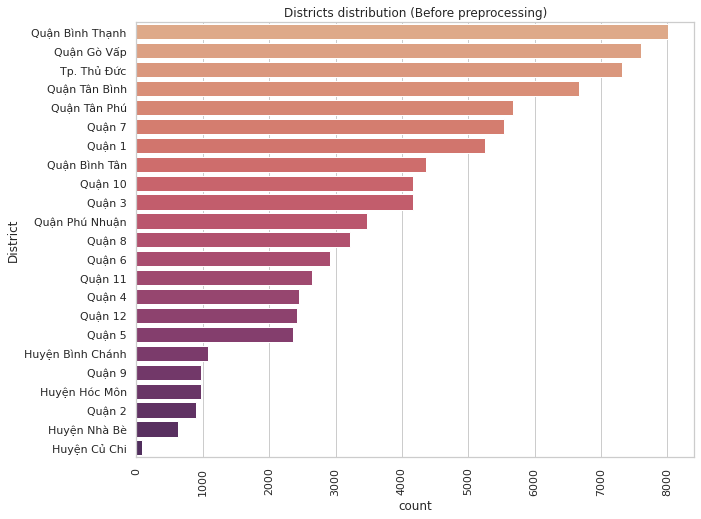

In [ ]:
# Before preprocessing
plt.figure(figsize = (10,8))
plt.title('Districts distribution (Before preprocessing)')
plt.xticks(rotation=90)
ax = sns.countplot(
    y = df_0['District'],
    order = df_0['District'].value_counts(ascending=False).index,
    palette = 'flare',
)

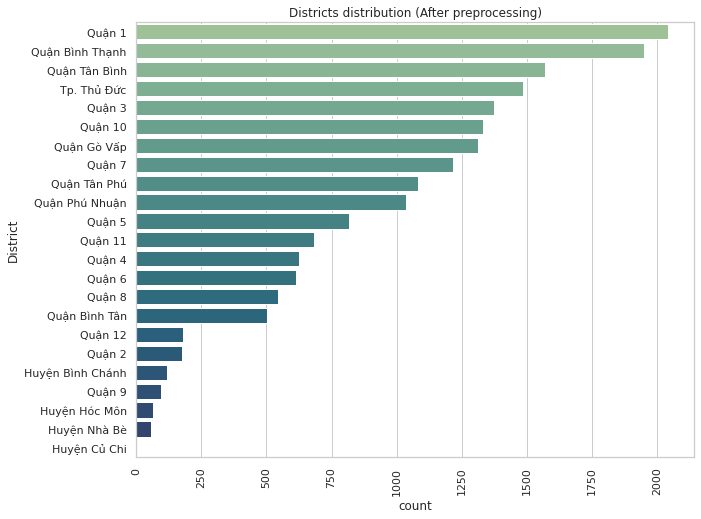

In [ ]:
# After preprocessing
plt.figure(figsize = (10,8))
plt.title('Districts distribution (After preprocessing)')
plt.xticks(rotation=90)
ax = sns.countplot(
    y = df['District'],
    order = df['District'].value_counts(ascending=False).index,
    palette = 'crest',
)

### 3.2. Average Rating distribution

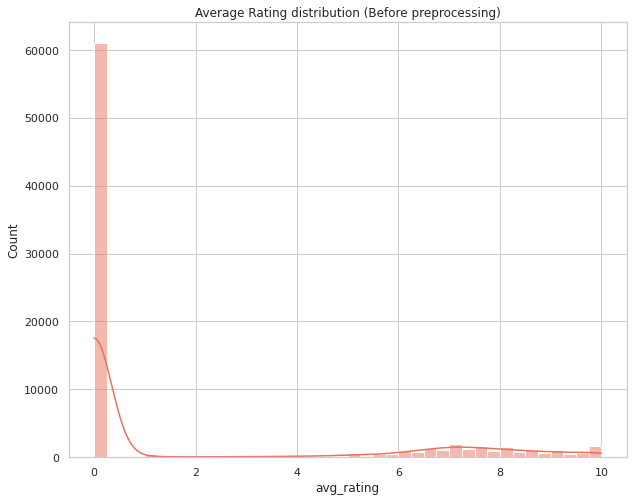

In [ ]:
# Before preprocessing
plt.figure(figsize = (10,8))
plt.title('Average Rating distribution (Before preprocessing)')
ax = sns.histplot(
    x = df_0['avg_rating'],
    kde = True,
    color = '#e8725f',
    bins = 40,
)

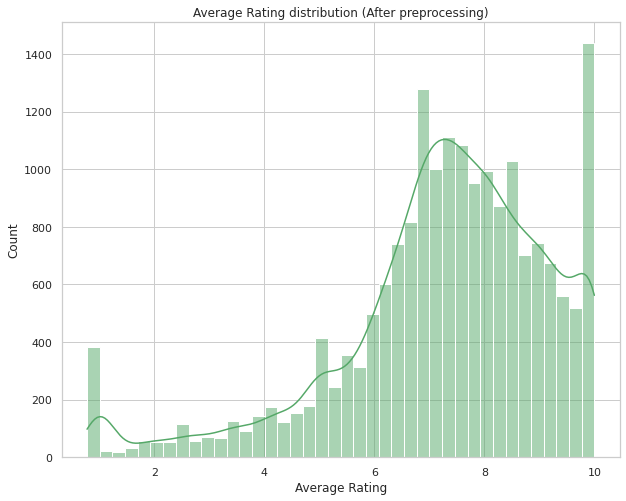

In [ ]:
# After preprocessing
plt.figure(figsize = (10,8))
plt.title('Average Rating distribution (After preprocessing)')
ax = sns.histplot(
    x = df['Average Rating'],
    kde = True,
    color='g',
    bins = 40,
)

### 3.3. Total Duration distribution

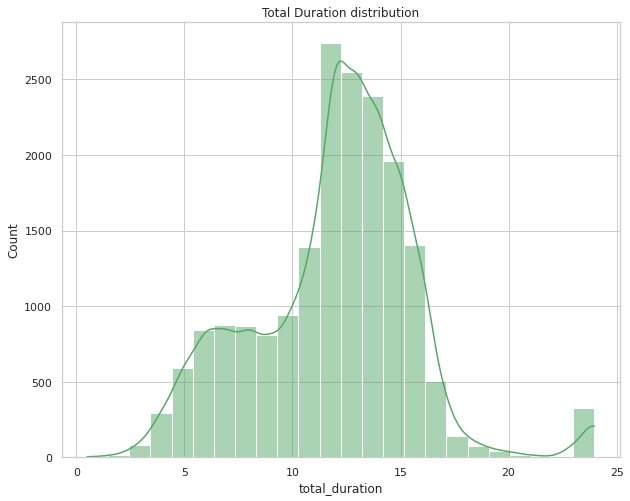

In [ ]:
# Total Duration distribution
plt.figure(figsize = (10,8))
plt.title('Total Duration distribution')
ax = sns.histplot(
    x = df['total_duration'],
    kde = True,
    color = 'g',
    bins = 24,
)

### 3.4. Correlations

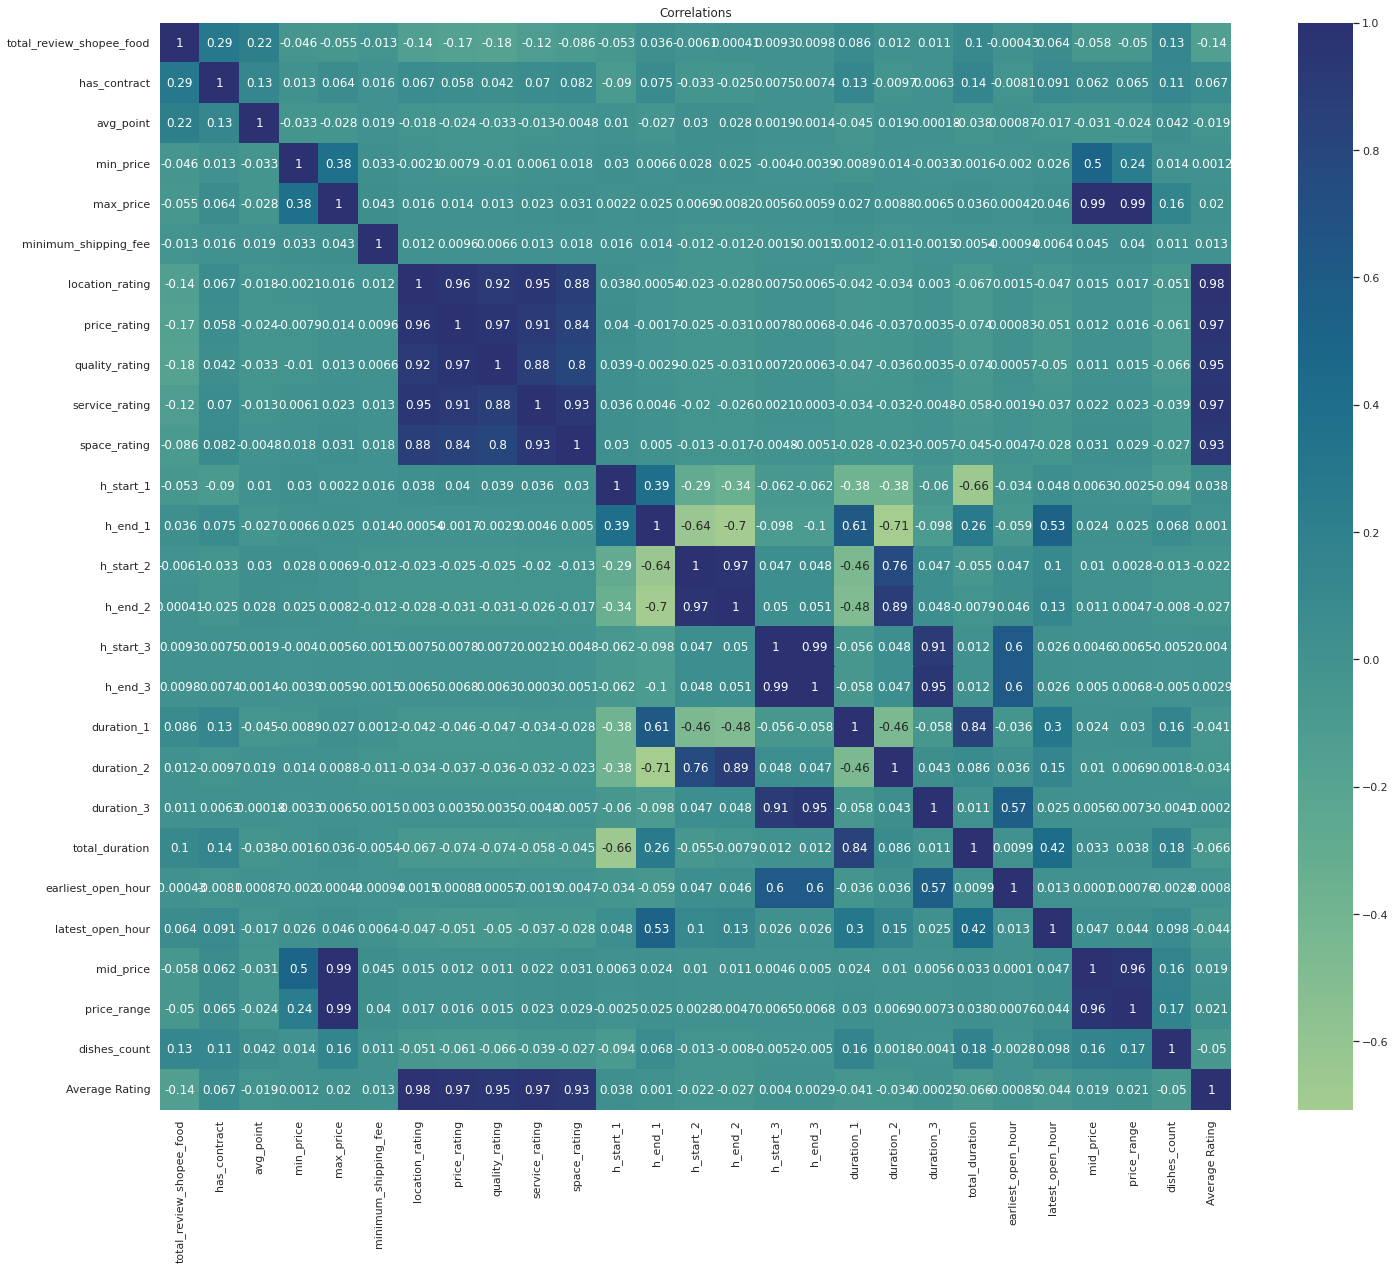

In [ ]:
# Correlations
plt.figure(figsize = (24,20))
plt.title('Correlations')
ax = sns.heatmap(
    data = df.corr(), 
    annot = True, 
    cmap = 'crest'
)

### 3.5. Comparison between districts

#### By `max_price`

In [ ]:
df_d = df[['District', 'max_price', 'total_duration', 'Average Rating']].groupby(['District']).mean()

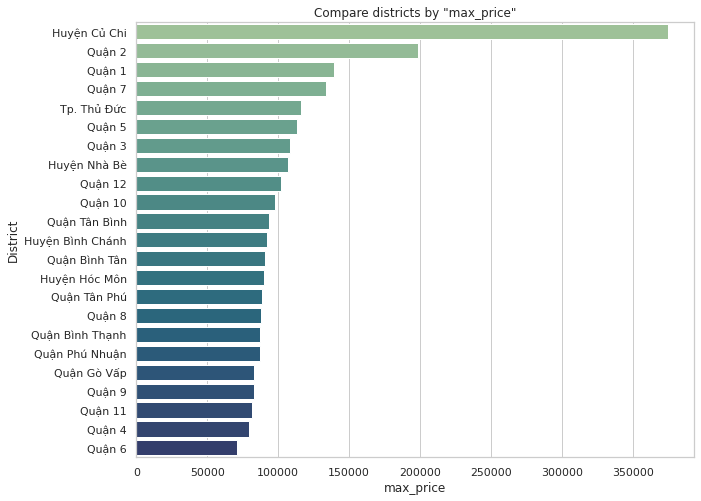

In [ ]:
examined_feature = 'max_price'
plt.figure(figsize = (10,8))
plt.title('Compare districts by "' + examined_feature + '"')
ax = sns.barplot(
    x = df[examined_feature],
    y = df['District'],
    order = df_d[examined_feature].sort_values(ascending=False).index,
    palette = 'crest',
    ci = 0,
)

#### By `total_duration`

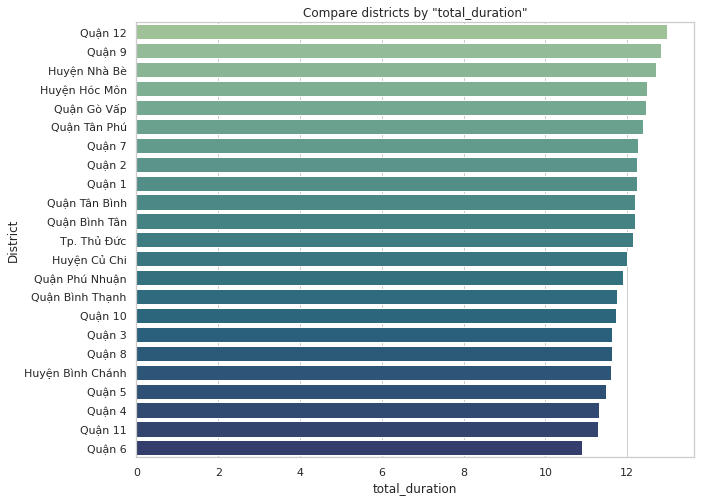

In [ ]:
examined_feature = 'total_duration'
plt.figure(figsize = (10,8))
plt.title('Compare districts by "' + examined_feature + '"')
ax = sns.barplot(
    x = df[examined_feature],
    y = df['District'],
    order = df_d[examined_feature].sort_values(ascending=False).index,
    palette = 'crest',
    ci = 0,
)

#### By `Average Rating`

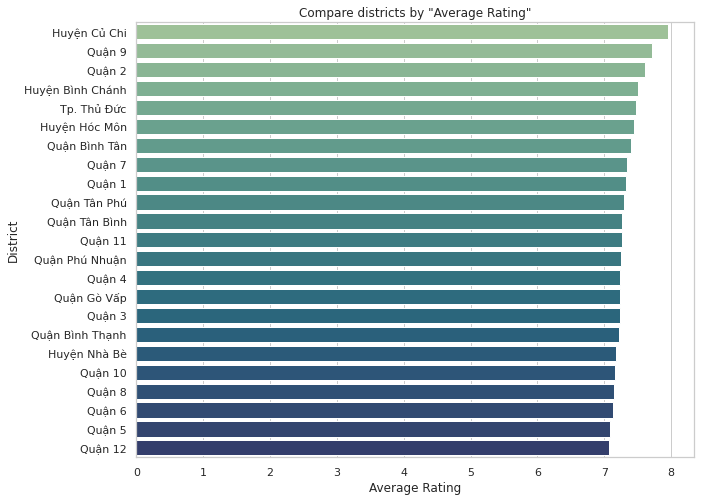

In [ ]:
examined_feature = 'Average Rating'
plt.figure(figsize = (10,8))
plt.title('Compare districts by "' + examined_feature + '"')
ax = sns.barplot(
    x = df[examined_feature],
    y = df['District'],
    order = df_d[examined_feature].sort_values(ascending=False).index,
    palette = 'crest',
    ci = 0,
)

### ----

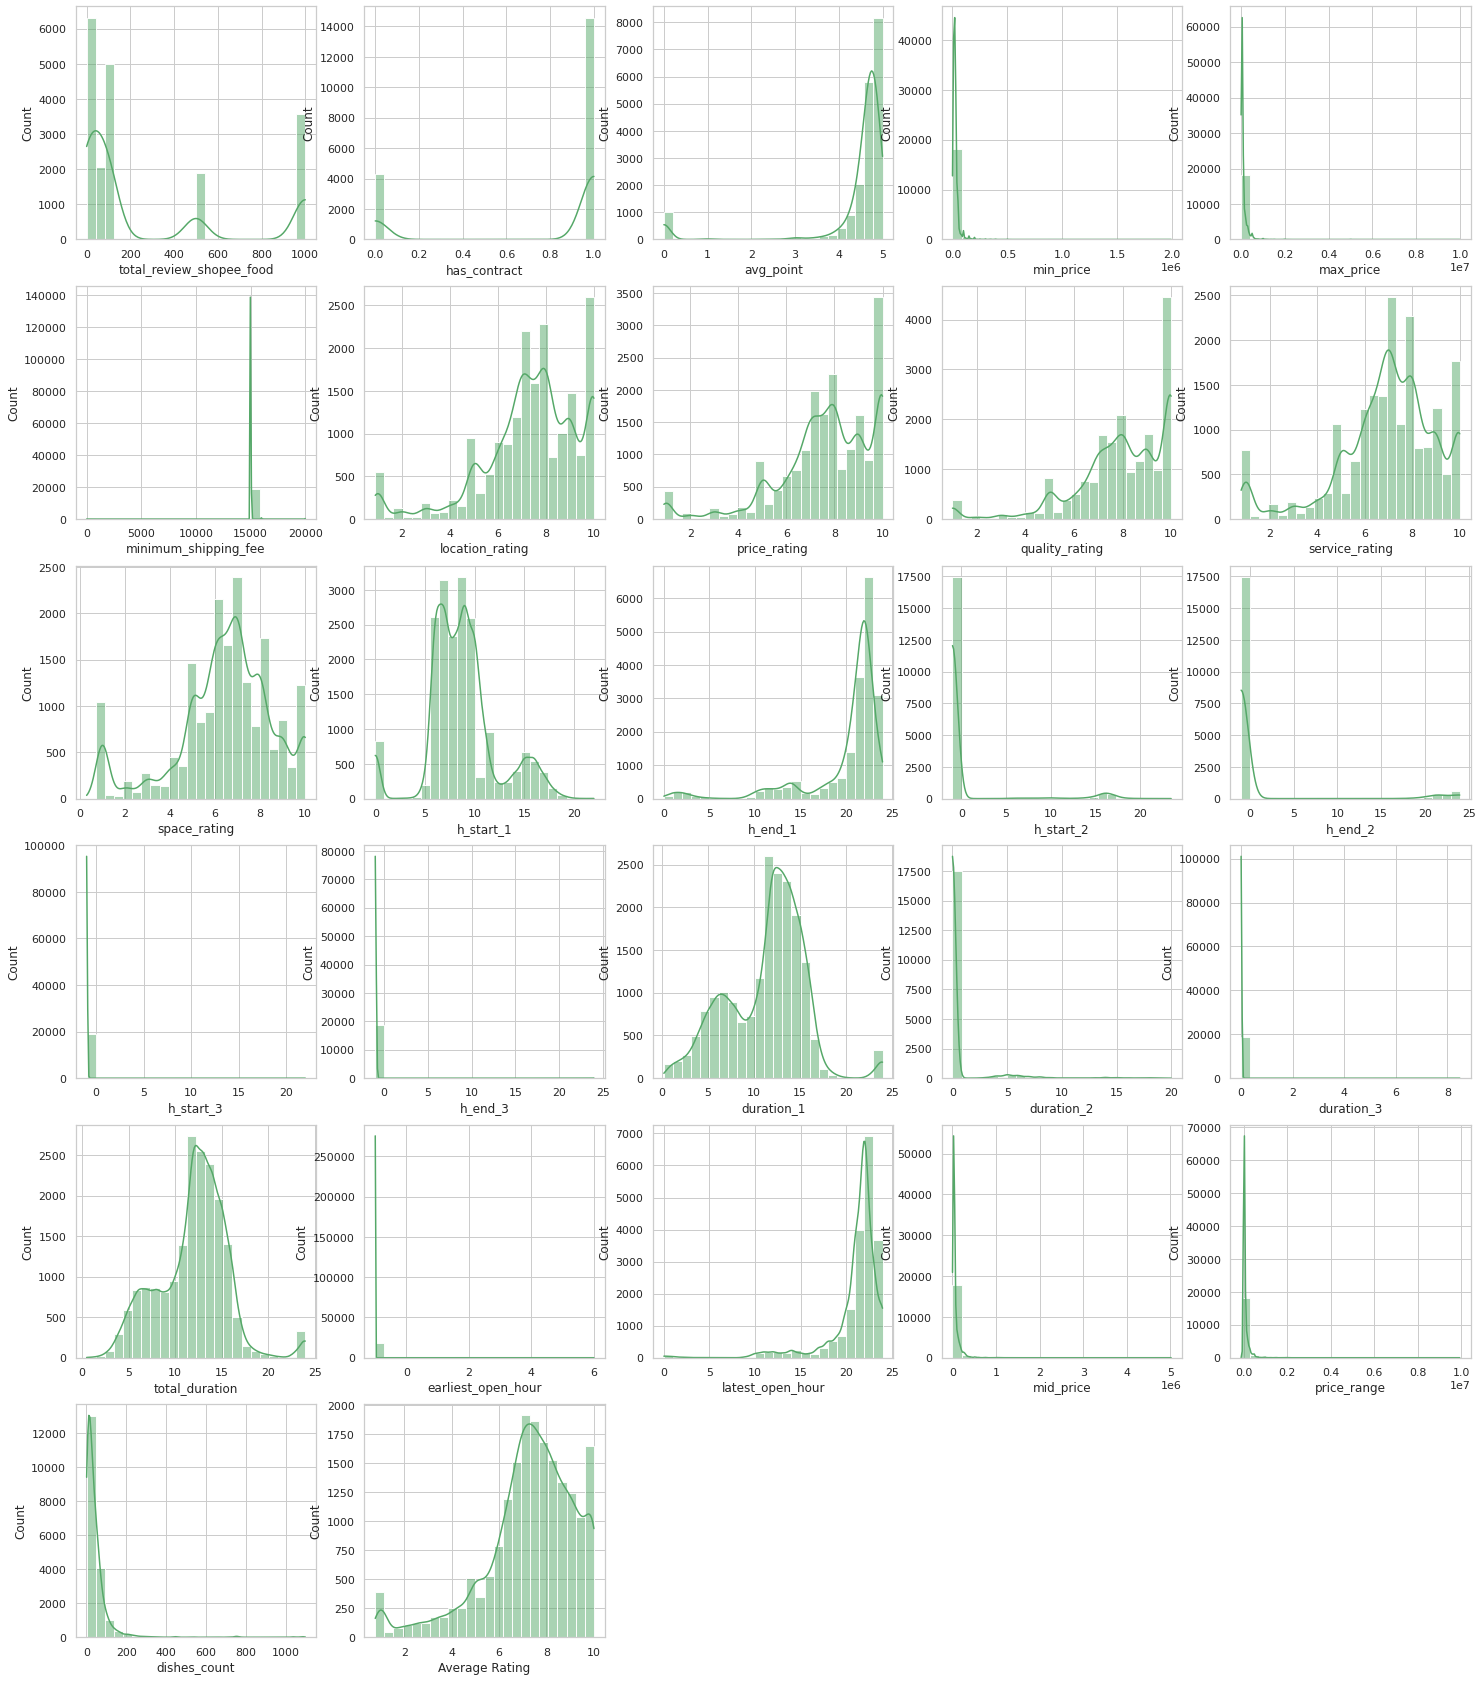

In [ ]:
# All numerical features distribution
df_num = df.select_dtypes(include = ['float64', 'int64'])

plt.figure(figsize = (25, 30))
for i, col in enumerate(df_num.columns):
  plt.subplot(6, 5, i+1)
  sns.histplot(
    x = df[col], 
    kde = True, 
    color = 'g',
    bins = 24,
  )

# III. Models Building

In [ ]:
# Hyperparameter
MAX_DEPTH_DTC = 6
MAX_DEPTH_RFC = 6
MAX_DEPTH_XGB = 6
AVERAGE_RATING_THRESHOLD =      8.0            # >=
REVIEWS_COUNT_THRESHOLD =       100            # >=
REVIEWS_COUNT_WORST_THRESHOLD =  50            # >=
F1_SCORE_LABEL = 'Good'

## 1. Preparation: Label, encode, sampling

### Labeling

In [ ]:
def average_rate_labeling(x, y=0):
  if x >= AVERAGE_RATING_THRESHOLD:
    return 'Good'
  else:
    return 'Bad'

In [ ]:
df_2 = df.copy()
df_2 = df_2[[
  # Categorical
  'Categories', 'Cuisines', 'District',
  # Numerical
  # 'has_contract',
  'total_review_shopee_food', 'min_price', 'max_price', 'minimum_shipping_fee', # 'avg_point'
  'price_range', 'mid_price', 'dishes_count',
  # 'h_start_1', 'h_end_1', 'h_start_2', 'h_end_2', 'h_start_3', 'h_end_3',
  # 'duration_1', 'duration_2', 'duration_3', 
  'earliest_open_hour', 'latest_open_hour',
  'total_duration', 'Average Rating'
]]

# Remove row that have the price equal to zero
df_2 = df_2[df_2['max_price'] != 0.0]

# Labeling the Rate Average
df_2['Label'] = df_2['Average Rating'].apply(func = average_rate_labeling)
df_2.drop(columns=['Average Rating'], inplace=True)

### One-hot encoding

In [ ]:
def one_hot_encode(item, value_of_row):
  if value_of_row != value_of_row: # value_of_row is NaN
    return 0
  elif item in value_of_row:
    return 1
  else:
    return 0

# One-hot encode Categories
for item in ls_categories:
  df_2['cat_'+item.replace('.', '').replace(' ', '').replace('/', '')] = df.apply(lambda row: one_hot_encode(item, row['Categories']), axis=1)

# One-hot encode Cuisines
for item in ls_cuisines:
  df_2['cui_'+item.replace('.', '').replace(' ', '').replace('/', '')] = df.apply(lambda row: one_hot_encode(item, row['Cuisines']), axis=1)

# One-hot encode District
for item in ls_districts:
  df_2['loc_'+item.replace('.', '').replace(' ', '').replace('/', '')] = df.apply(lambda row: one_hot_encode(item, row['District']), axis=1)

df_2.drop(columns=['Categories'], inplace=True)
df_2.drop(columns=['Cuisines'], inplace=True)
df_2.drop(columns=['District'], inplace=True)

<ipython-input-60-744b33f9dc7c>:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_2['loc_'+item.replace('.', '').replace(' ', '').replace('/', '')] = df.apply(lambda row: one_hot_encode(item, row['District']), axis=1)


In [ ]:
# Handle reviews count
df_low_reviews_count = df_2[
  (df_2['total_review_shopee_food'] < REVIEWS_COUNT_THRESHOLD)
  &
  (df_2['total_review_shopee_food'] >= REVIEWS_COUNT_WORST_THRESHOLD)
] # The low reviews count df
df_low_reviews_count.drop(columns=['total_review_shopee_food'], inplace=True)

df_2 = df_2[df_2['total_review_shopee_food'] >= REVIEWS_COUNT_THRESHOLD]
df_2.drop(columns=['total_review_shopee_food'], inplace=True)

### Train/Test Splitting

In [ ]:
df_3 = df_2.copy()

# Features
X = df_2.drop('Label', axis=1)
y = df_2['Label']

feature_names = list(X.columns)
print(feature_names)

label_names = list(y.unique())
print(label_names)

# Not important: The low reviews count df
X_low_reviews_count = df_low_reviews_count.drop('Label', axis=1)
y_low_reviews_count = df_low_reviews_count['Label']

['min_price', 'max_price', 'minimum_shipping_fee', 'price_range', 'mid_price', 'dishes_count', 'earliest_open_hour', 'latest_open_hour', 'total_duration', 'cat_Nhàhàng', 'cat_Ănvặtvỉahè', 'cat_Quánăn', 'cat_Tiệmbánh', 'cat_Buffet', 'cat_Beerclub', 'cat_ShopCửahàng', 'cat_CaféDessert', 'cat_Sangtrọng', 'cat_Giaocơmvănphòng', 'cat_Ănchay', 'cat_ShopOnline', 'cat_Quánnhậu', 'cat_BarPub', 'cat_Chợ', 'cat_KhuẨmThực', 'cat_MuasắmOnline', 'cat_Rạpchiếuphim', 'cat_Tiệctậnnơi', 'cat_Siêuthị', 'cat_Hoacưới-Shophoa', 'cat_TiệccướiHộinghị', 'cat_Vậtnuôi', 'cat_Nhàthuốc', 'cat_Trungtâmthươngmại', 'cat_Shophóamỹphẩm', 'cat_Billiards', 'cat_KhuchơiGame', 'cat_SpaMassage', 'cat_Thămquan&chụpảnh', 'cat_Kháchsạn', 'cui_MónÂu', 'cui_MónThái', 'cui_MónÁ', 'cui_MónMiềnNam', 'cui_MónTrungHoa', 'cui_MónMiềnTrung', 'cui_NhaTrang', 'cui_MónNhật', 'cui_ĐàiLoan', 'cui_ChâuMỹ', 'cui_Mỹ', 'cui_Quốctế', 'cui_Ý', 'cui_MónBắc', 'cui_HàNội', 'cui_MónViệt', 'cui_Đặcsảnvùng', 'cui_Philippines', 'cui_MónHàn', 'cui_MónHuế

In [ ]:
y.value_counts()

Bad     7378
Good    2917
Name: Label, dtype: int64

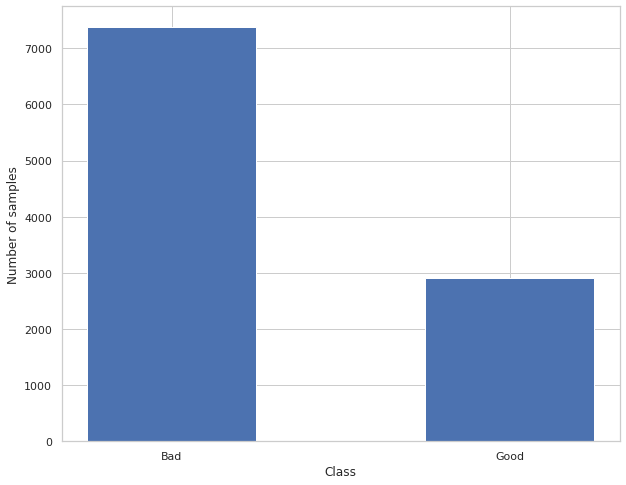

In [ ]:
plt.figure(figsize = (10,8))
plt.bar(
  ['Bad', 'Good'],
  [y.value_counts()[0], y.value_counts()[1]],
  # color = 'g',
  width = 0.5,
)
plt.xlabel("Class")
plt.ylabel("Number of samples")
plt.show()

In [ ]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size = 0.2,
    random_state = 100, # <------------------------- Seed
)

### Sampling

#### Original

In [ ]:
X_train_original = X_train.copy()
y_train_original = y_train.copy()

y_train_original.value_counts()

Bad     5869
Good    2367
Name: Label, dtype: int64

#### Random Under Sampling

In [ ]:
X_train_undersam = X_train.copy()
y_train_undersam = y_train.copy()

y_train_undersam.value_counts()

Bad     5869
Good    2367
Name: Label, dtype: int64

In [ ]:
# Under Sampling
from imblearn.under_sampling import RandomUnderSampler
undersam = RandomUnderSampler(
  sampling_strategy='majority',
  random_state = 100,
)

X_train_undersam, y_train_undersam = undersam.fit_resample(X_train_undersam, y_train_undersam)

In [ ]:
y_train_undersam.value_counts()

Bad     2367
Good    2367
Name: Label, dtype: int64

#### Random Over Sampling

In [ ]:
X_train_oversam = X_train.copy()
y_train_oversam = y_train.copy()

y_train_oversam.value_counts()

Bad     5869
Good    2367
Name: Label, dtype: int64

In [ ]:
# Random Over Sampling
from imblearn.over_sampling import RandomOverSampler
oversam = RandomOverSampler(
  sampling_strategy='minority',
  random_state = 100,
)

X_train_oversam, y_train_oversam = oversam.fit_resample(X_train_oversam, y_train_oversam)

In [ ]:
y_train_oversam.value_counts()

Bad     5869
Good    5869
Name: Label, dtype: int64

#### SMOTE

In [ ]:
X_train_smote = X_train.copy()
y_train_smote = y_train.copy()

y_train_smote.value_counts()

Bad     5869
Good    2367
Name: Label, dtype: int64

In [ ]:
# # SMOTE
from imblearn.over_sampling import SMOTE
smote = SMOTE(
  sampling_strategy = 'minority',
  random_state = 100,
  k_neighbors = 2,
)

X_train_smote, y_train_smote = smote.fit_resample(X_train_smote, y_train_smote)

In [ ]:
y_train_smote.value_counts()

Bad     5869
Good    5869
Name: Label, dtype: int64

#### ADASYN

In [ ]:
X_train_adasyn = X_train.copy()
y_train_adasyn = y_train.copy()

y_train_adasyn.value_counts()

Bad     5869
Good    2367
Name: Label, dtype: int64

In [ ]:
# # ADASYN
from imblearn.over_sampling import ADASYN
adasyn = ADASYN(
  sampling_strategy = 'minority',
  random_state = 100,
  # k_neighbors = 2,
)

X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_adasyn, y_train_adasyn)

In [ ]:
y_train_adasyn.value_counts()

Bad     5869
Good    5795
Name: Label, dtype: int64

## 2. Overfitting analysis to choose the best models

### Train 3 models x 5 sampling methods

In [ ]:
max_depth_ls = [i for i in range(1, 11)]
X_trains = [X_train_original, X_train_undersam, X_train_oversam, X_train_smote, X_train_adasyn]
y_trains = [y_train_original, y_train_undersam, y_train_oversam, y_train_smote, y_train_adasyn]

model_names = ['Decision Tree', 'Random Forest', 'XGBoost']
sampling_methods = ['Original', 'RandomUnderSampling', 'RandomOverSampling', 'SMOTE', 'ADASYN']

train_accs = [
  # DTC
  [
    [], # Original
    [], # RandomUnderSampling
    [], # RandomOverSampling
    [], # SMOTE
    [], # ADASYN
  ],
  # RFC
  [
    [], # Original
    [], # RandomUnderSampling
    [], # RandomOverSampling
    [], # SMOTE
    [], # ADASYN
  ],
  # XGB
  [
    [], # Original
    [], # RandomUnderSampling
    [], # RandomOverSampling
    [], # SMOTE
    [], # ADASYN
  ],
]
test_accs  = [
  # DTC
  [
    [], # Original
    [], # RandomUnderSampling
    [], # RandomOverSampling
    [], # SMOTE
    [], # ADASYN
  ],
  # RFC
  [
    [], # Original
    [], # RandomUnderSampling
    [], # RandomOverSampling
    [], # SMOTE
    [], # ADASYN
  ],
  # XGB
  [
    [], # Original
    [], # RandomUnderSampling
    [], # RandomOverSampling
    [], # SMOTE
    [], # ADASYN
  ],
]
low_reviews_count_accs = [
  # DTC
  [
    [], # Original
    [], # RandomUnderSampling
    [], # RandomOverSampling
    [], # SMOTE
    [], # ADASYN
  ],
  # RFC
  [
    [], # Original
    [], # RandomUnderSampling
    [], # RandomOverSampling
    [], # SMOTE
    [], # ADASYN
  ],
  # XGB
  [
    [], # Original
    [], # RandomUnderSampling
    [], # RandomOverSampling
    [], # SMOTE
    [], # ADASYN
  ],
]

train_f1_scores = [
  # DTC
  [
    [], # Original
    [], # RandomUnderSampling
    [], # RandomOverSampling
    [], # SMOTE
    [], # ADASYN
  ],
  # RFC
  [
    [], # Original
    [], # RandomUnderSampling
    [], # RandomOverSampling
    [], # SMOTE
    [], # ADASYN
  ],
  # XGB
  [
    [], # Original
    [], # RandomUnderSampling
    [], # RandomOverSampling
    [], # SMOTE
    [], # ADASYN
  ],
]
test_f1_scores  = [
  # DTC
  [
    [], # Original
    [], # RandomUnderSampling
    [], # RandomOverSampling
    [], # SMOTE
    [], # ADASYN
  ],
  # RFC
  [
    [], # Original
    [], # RandomUnderSampling
    [], # RandomOverSampling
    [], # SMOTE
    [], # ADASYN
  ],
  # XGB
  [
    [], # Original
    [], # RandomUnderSampling
    [], # RandomOverSampling
    [], # SMOTE
    [], # ADASYN
  ],
]
low_reviews_count_f1_scores = [
  # DTC
  [
    [], # Original
    [], # RandomUnderSampling
    [], # RandomOverSampling
    [], # SMOTE
    [], # ADASYN
  ],
  # RFC
  [
    [], # Original
    [], # RandomUnderSampling
    [], # RandomOverSampling
    [], # SMOTE
    [], # ADASYN
  ],
  # XGB
  [
    [], # Original
    [], # RandomUnderSampling
    [], # RandomOverSampling
    [], # SMOTE
    [], # ADASYN
  ],
]

In [ ]:
for model_i in range(3):
  for sampling_i in range(len(X_trains)):
    for max_depth in max_depth_ls:
      if (model_i == 0):
        model = DecisionTreeClassifier(max_depth = max_depth)
      elif (model_i == 1):
        model = RandomForestClassifier(max_depth = max_depth)
      elif (model_i == 2):
        model = XGBClassifier(max_depth = max_depth)
      model = model.fit(X_trains[sampling_i], y_trains[sampling_i])
      # Accuracy Score
      train_accs[model_i][sampling_i].append(model.score(X_trains[sampling_i], y_trains[sampling_i]))
      test_accs[model_i][sampling_i].append(model.score(X_test, y_test))
      low_reviews_count_accs[model_i][sampling_i].append(model.score(X_low_reviews_count, y_low_reviews_count))
      # F1 Score
      train_f1_scores[model_i][sampling_i].append(metrics.f1_score(y_trains[sampling_i], model.predict(X_trains[sampling_i]), pos_label = F1_SCORE_LABEL))
      test_f1_scores[model_i][sampling_i].append(metrics.f1_score(y_test, model.predict(X_test), pos_label = F1_SCORE_LABEL))
      low_reviews_count_f1_scores[model_i][sampling_i].append(metrics.f1_score(y_low_reviews_count, model.predict(X_low_reviews_count), pos_label = F1_SCORE_LABEL))

### Results

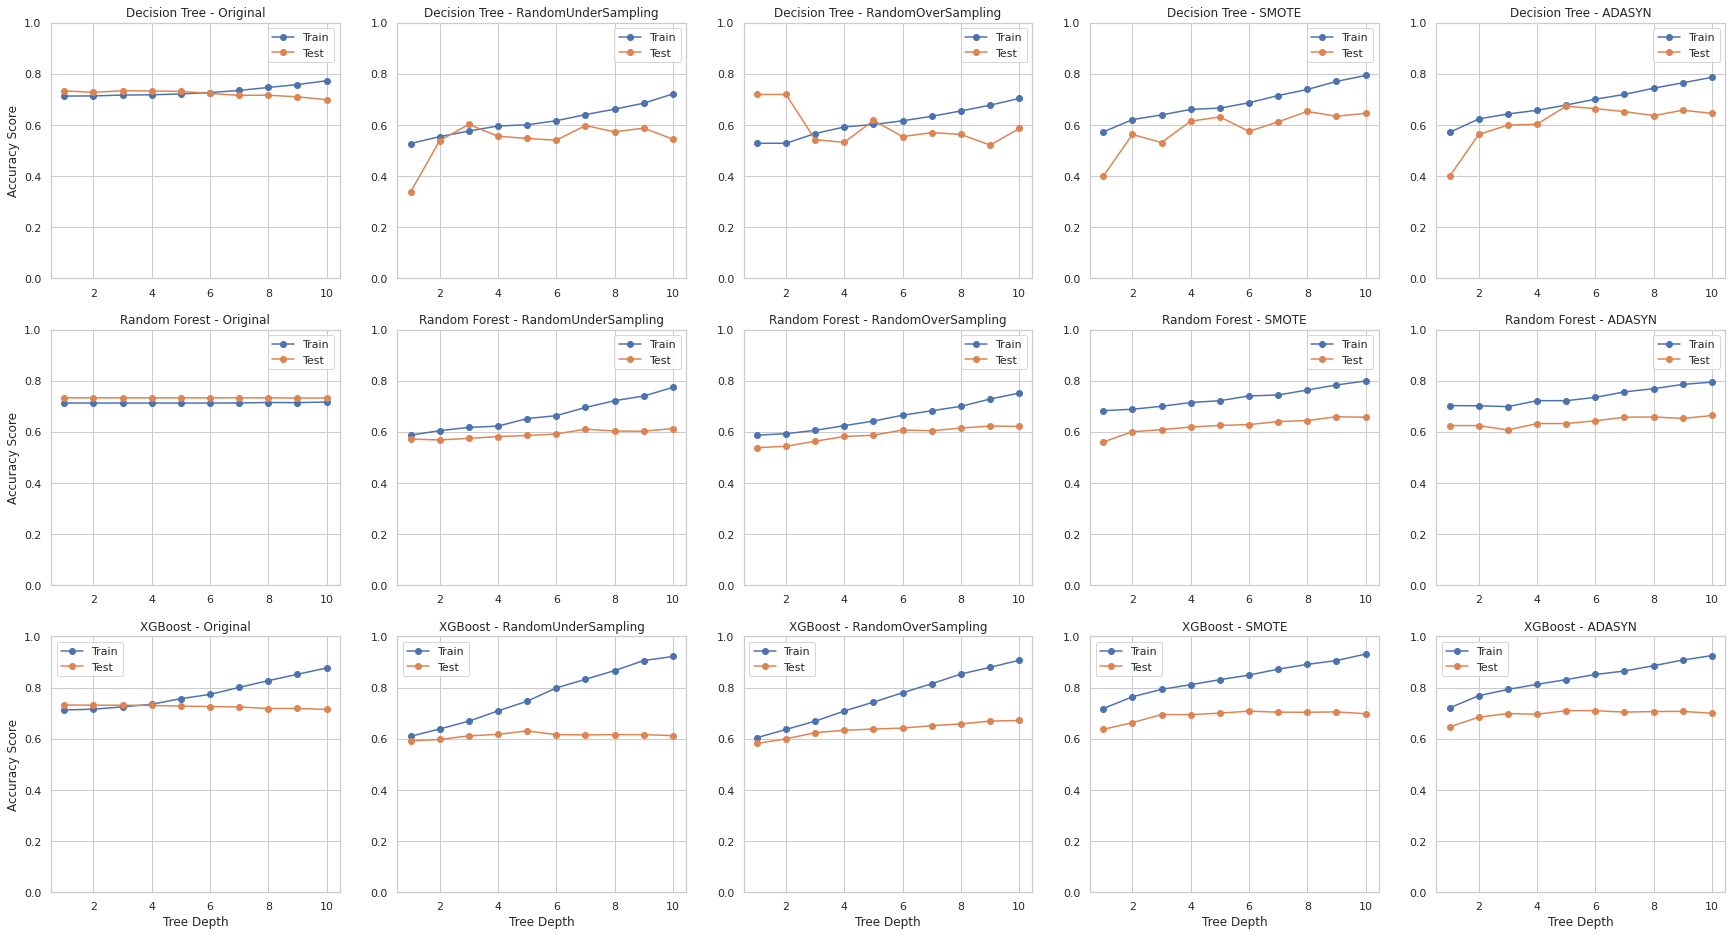

In [ ]:
figure, axis = plt.subplots(3, len(X_trains), figsize=(30, 16))
for i in range(3):
  for u in range(len(X_trains)):
    axis[i, u].plot(max_depth_ls, train_accs[i][u], '-o', label='Train')
    axis[i, u].plot(max_depth_ls, test_accs[i][u], '-o', label='Test')
    # axis[i, u].plot(max_depth_ls, low_reviews_count_accs[i][u], '-o', label='Low Reviews Count')
    axis[i, u].set_title(model_names[i] + ' - ' + sampling_methods[u])
    axis[i, u].legend()
    axis[i, u].axis(ymin = 0.0, ymax = 1.0)
    if (i == 2):
      axis[i, u].set(xlabel='Tree Depth')
    if (u == 0):
      axis[i, u].set(ylabel='Accuracy Score')
plt.show()

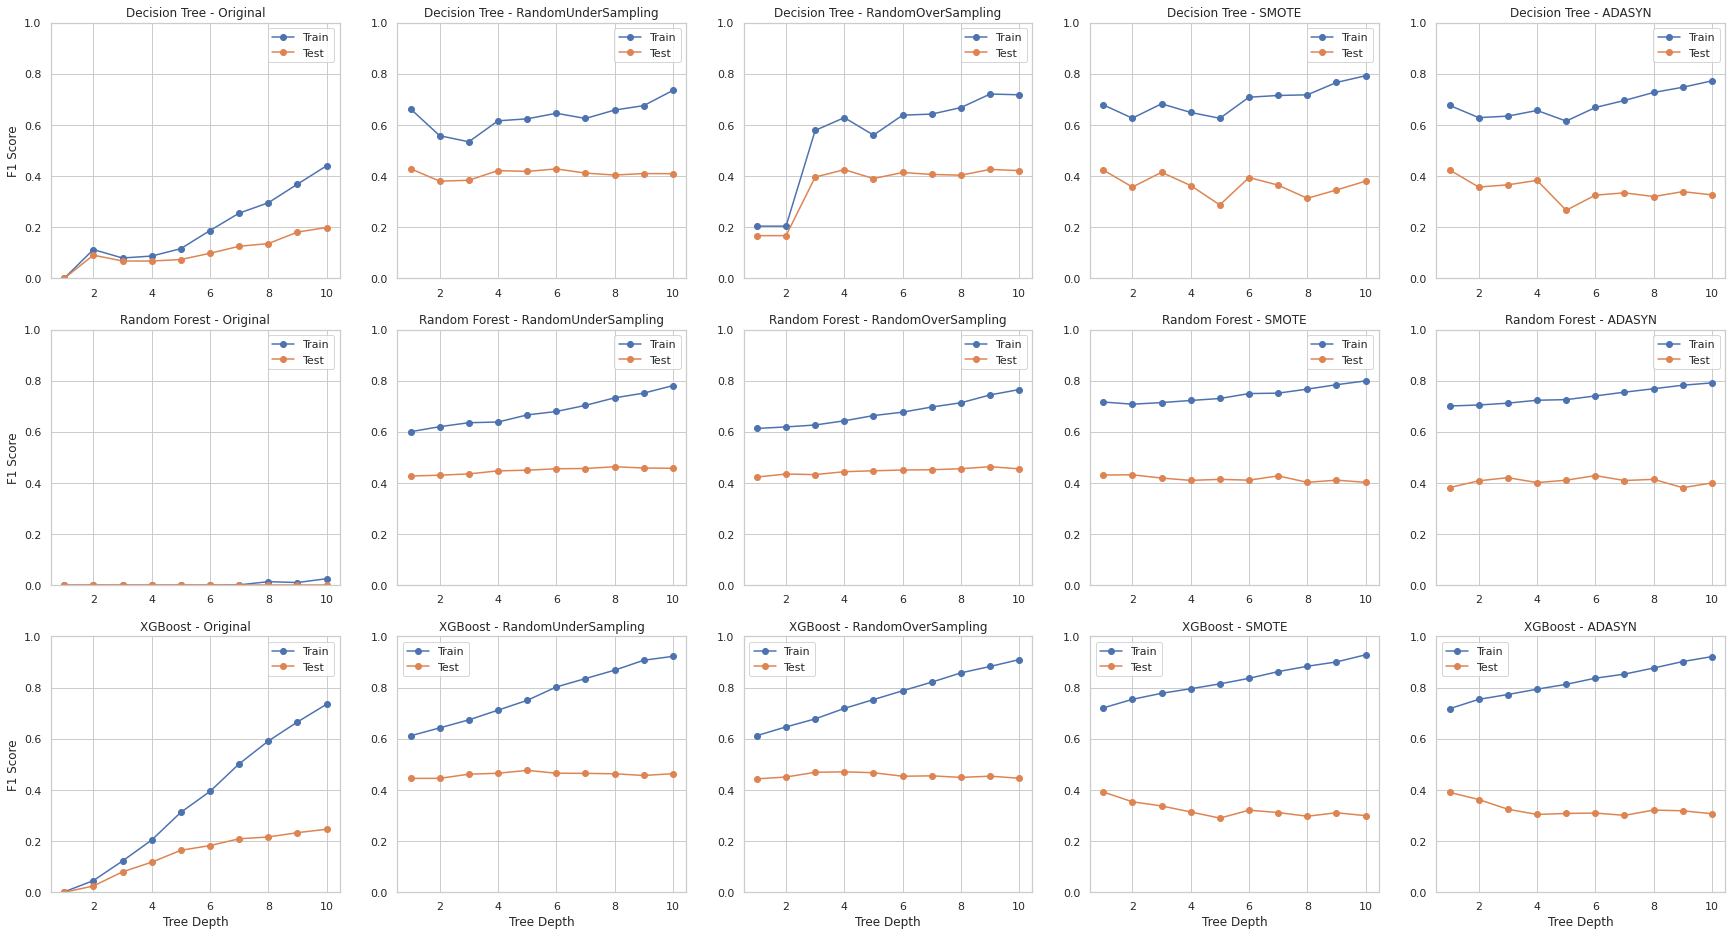

In [ ]:
figure, axis = plt.subplots(3, len(X_trains), figsize=(30, 16))
for i in range(3):
  for u in range(len(X_trains)):
    axis[i, u].plot(max_depth_ls, train_f1_scores[i][u], '-o', label='Train')
    axis[i, u].plot(max_depth_ls, test_f1_scores[i][u], '-o', label='Test')
    # axis[i, u].plot(max_depth_ls, low_reviews_count_f1_scores[i][u], '-o', label='Low Reviews Count')
    axis[i, u].set_title(model_names[i] + ' - ' + sampling_methods[u])
    axis[i, u].legend()
    axis[i, u].axis(ymin = 0.0, ymax = 1.0)
    if (i == 2):
      axis[i, u].set(xlabel='Tree Depth')
    if (u == 0):
      axis[i, u].set(ylabel='F1 Score')
plt.show()

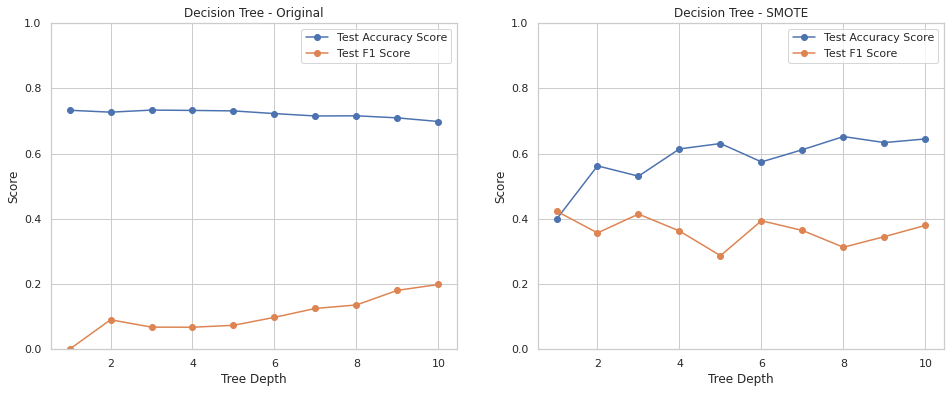

In [ ]:
i = 0
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
u = 0
# ax1.plot(max_depth_ls, train_accs[i][u], '-o', label='Train Accuracy')
ax1.plot(max_depth_ls, test_accs[i][u], '-o', label='Test Accuracy Score')
# ax1.plot(max_depth_ls, train_f1_scores[i][u], '-o', label='Train F1 Score')
ax1.plot(max_depth_ls, test_f1_scores[i][u], '-o', label='Test F1 Score')
ax1.set_title(model_names[i] + ' - ' + sampling_methods[u])
ax1.legend()
ax1.axis(ymin = 0.0, ymax = 1.0)
ax1.set(xlabel='Tree Depth', ylabel='Score')
u = 3
# ax2.plot(max_depth_ls, train_accs[i][u], '-o', label='Train Accuracy')
ax2.plot(max_depth_ls, test_accs[i][u], '-o', label='Test Accuracy Score')
# ax2.plot(max_depth_ls, train_f1_scores[i][u], '-o', label='Train F1 Score')
ax2.plot(max_depth_ls, test_f1_scores[i][u], '-o', label='Test F1 Score')
ax2.set_title(model_names[i] + ' - ' + sampling_methods[u])
ax2.legend()
ax2.axis(ymin = 0.0, ymax = 1.0)
ax2.set(xlabel='Tree Depth', ylabel='Score')
plt.show()

## 3. Models Building

In [ ]:
X_train = X_train_smote
y_train = y_train_smote

### 1. Decision Tree

In [ ]:
# Build Decision Tree Model
DTC_model = DecisionTreeClassifier(
  max_depth = MAX_DEPTH_DTC,
)

# Train Decision Tree Classifer
DTC_model = DTC_model.fit(X_train, y_train)

#Predict the labels for test dataset
y_pred = DTC_model.predict(X_test)

In [ ]:
# Evaluating Model

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Model Accuracy, how often is the classifier correct?
print("Accuracy (Train):", DTC_model.score(X_train, y_train))
print("Accuracy (Test) :", DTC_model.score(X_test, y_test)) # metrics.accuracy_score(y_test, y_pred)
print("Accuracy (Low Reviews Count) :", DTC_model.score(X_low_reviews_count, y_low_reviews_count))

[[898 611]
 [265 285]]
              precision    recall  f1-score   support

         Bad       0.77      0.60      0.67      1509
        Good       0.32      0.52      0.39       550

    accuracy                           0.57      2059
   macro avg       0.55      0.56      0.53      2059
weighted avg       0.65      0.57      0.60      2059

Accuracy (Train): 0.686317941727722
Accuracy (Test) : 0.5745507527926178
Accuracy (Low Reviews Count) : 0.5838323353293413


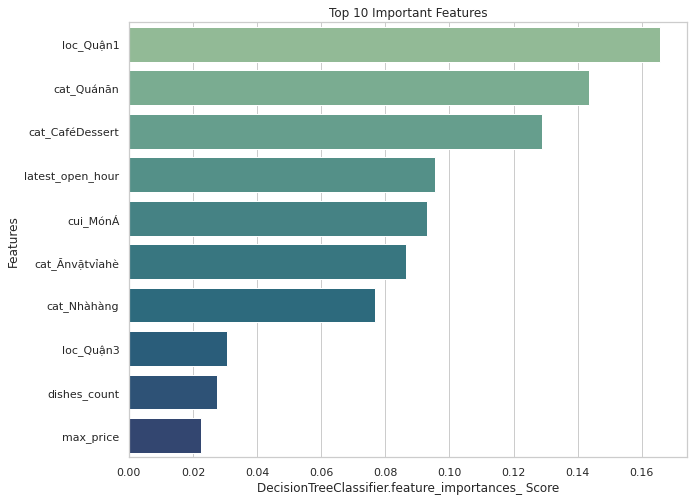

In [ ]:
# Find important features
feature_imp = pd.Series(DTC_model.feature_importances_, index=feature_names).sort_values(ascending=False)
num_feat = 10

plt.figure(figsize = (10,8))
sns.barplot(
  x = feature_imp[:num_feat], 
  y = feature_imp[:num_feat].index,
  palette = 'crest',
)
plt.xlabel('DecisionTreeClassifier.feature_importances_ Score')
plt.ylabel('Features')
plt.title("Top " + str(num_feat) + " Important Features")
plt.show()

In [ ]:
# Visualize Tree
print(
  tree.export_text(
    decision_tree = DTC_model,
    feature_names = feature_names,
  )
)

|--- loc_Quận1 <= 0.50
|   |--- cat_Quánăn <= 0.50
|   |   |--- cui_MónÁ <= 0.50
|   |   |   |--- cat_Nhàhàng <= 0.50
|   |   |   |   |--- cat_Ănvặtvỉahè <= 0.50
|   |   |   |   |   |--- cat_CaféDessert <= 0.50
|   |   |   |   |   |   |--- class: Good
|   |   |   |   |   |--- cat_CaféDessert >  0.50
|   |   |   |   |   |   |--- class: Good
|   |   |   |   |--- cat_Ănvặtvỉahè >  0.50
|   |   |   |   |   |--- loc_QuậnBìnhThạnh <= 0.50
|   |   |   |   |   |   |--- class: Good
|   |   |   |   |   |--- loc_QuậnBìnhThạnh >  0.50
|   |   |   |   |   |   |--- class: Bad
|   |   |   |--- cat_Nhàhàng >  0.50
|   |   |   |   |--- minimum_shipping_fee <= 15058.17
|   |   |   |   |   |--- price_range <= 362705.47
|   |   |   |   |   |   |--- class: Bad
|   |   |   |   |   |--- price_range >  362705.47
|   |   |   |   |   |   |--- class: Good
|   |   |   |   |--- minimum_shipping_fee >  15058.17
|   |   |   |   |   |--- cui_MónÂu <= 0.50
|   |   |   |   |   |   |--- class: Good
|   |   |   |   |   |

[Text(0.5049342105263158, 0.9285714285714286, 'loc_Quận1 <= 0.5\ngini = 0.5\nsamples = 11738\nvalue = [5869, 5869]\nclass = Bad'),
 Text(0.2675438596491228, 0.7857142857142857, 'cat_Quánăn <= 0.5\ngini = 0.496\nsamples = 9738\nvalue = [4445, 5293]\nclass = Good'),
 Text(0.14035087719298245, 0.6428571428571429, 'cui_MónÁ <= 0.5\ngini = 0.473\nsamples = 6042\nvalue = [2313, 3729]\nclass = Good'),
 Text(0.07017543859649122, 0.5, 'cat_Nhàhàng <= 0.5\ngini = 0.458\nsamples = 5587\nvalue = [1980, 3607]\nclass = Good'),
 Text(0.03508771929824561, 0.35714285714285715, 'cat_Ănvặtvỉahè <= 0.5\ngini = 0.444\nsamples = 5312\nvalue = [1768, 3544]\nclass = Good'),
 Text(0.017543859649122806, 0.21428571428571427, 'cat_CaféDessert <= 0.5\ngini = 0.396\nsamples = 3904\nvalue = [1063, 2841]\nclass = Good'),
 Text(0.008771929824561403, 0.07142857142857142, 'gini = 0.275\nsamples = 2539\nvalue = [418, 2121]\nclass = Good'),
 Text(0.02631578947368421, 0.07142857142857142, 'gini = 0.498\nsamples = 1365\nval

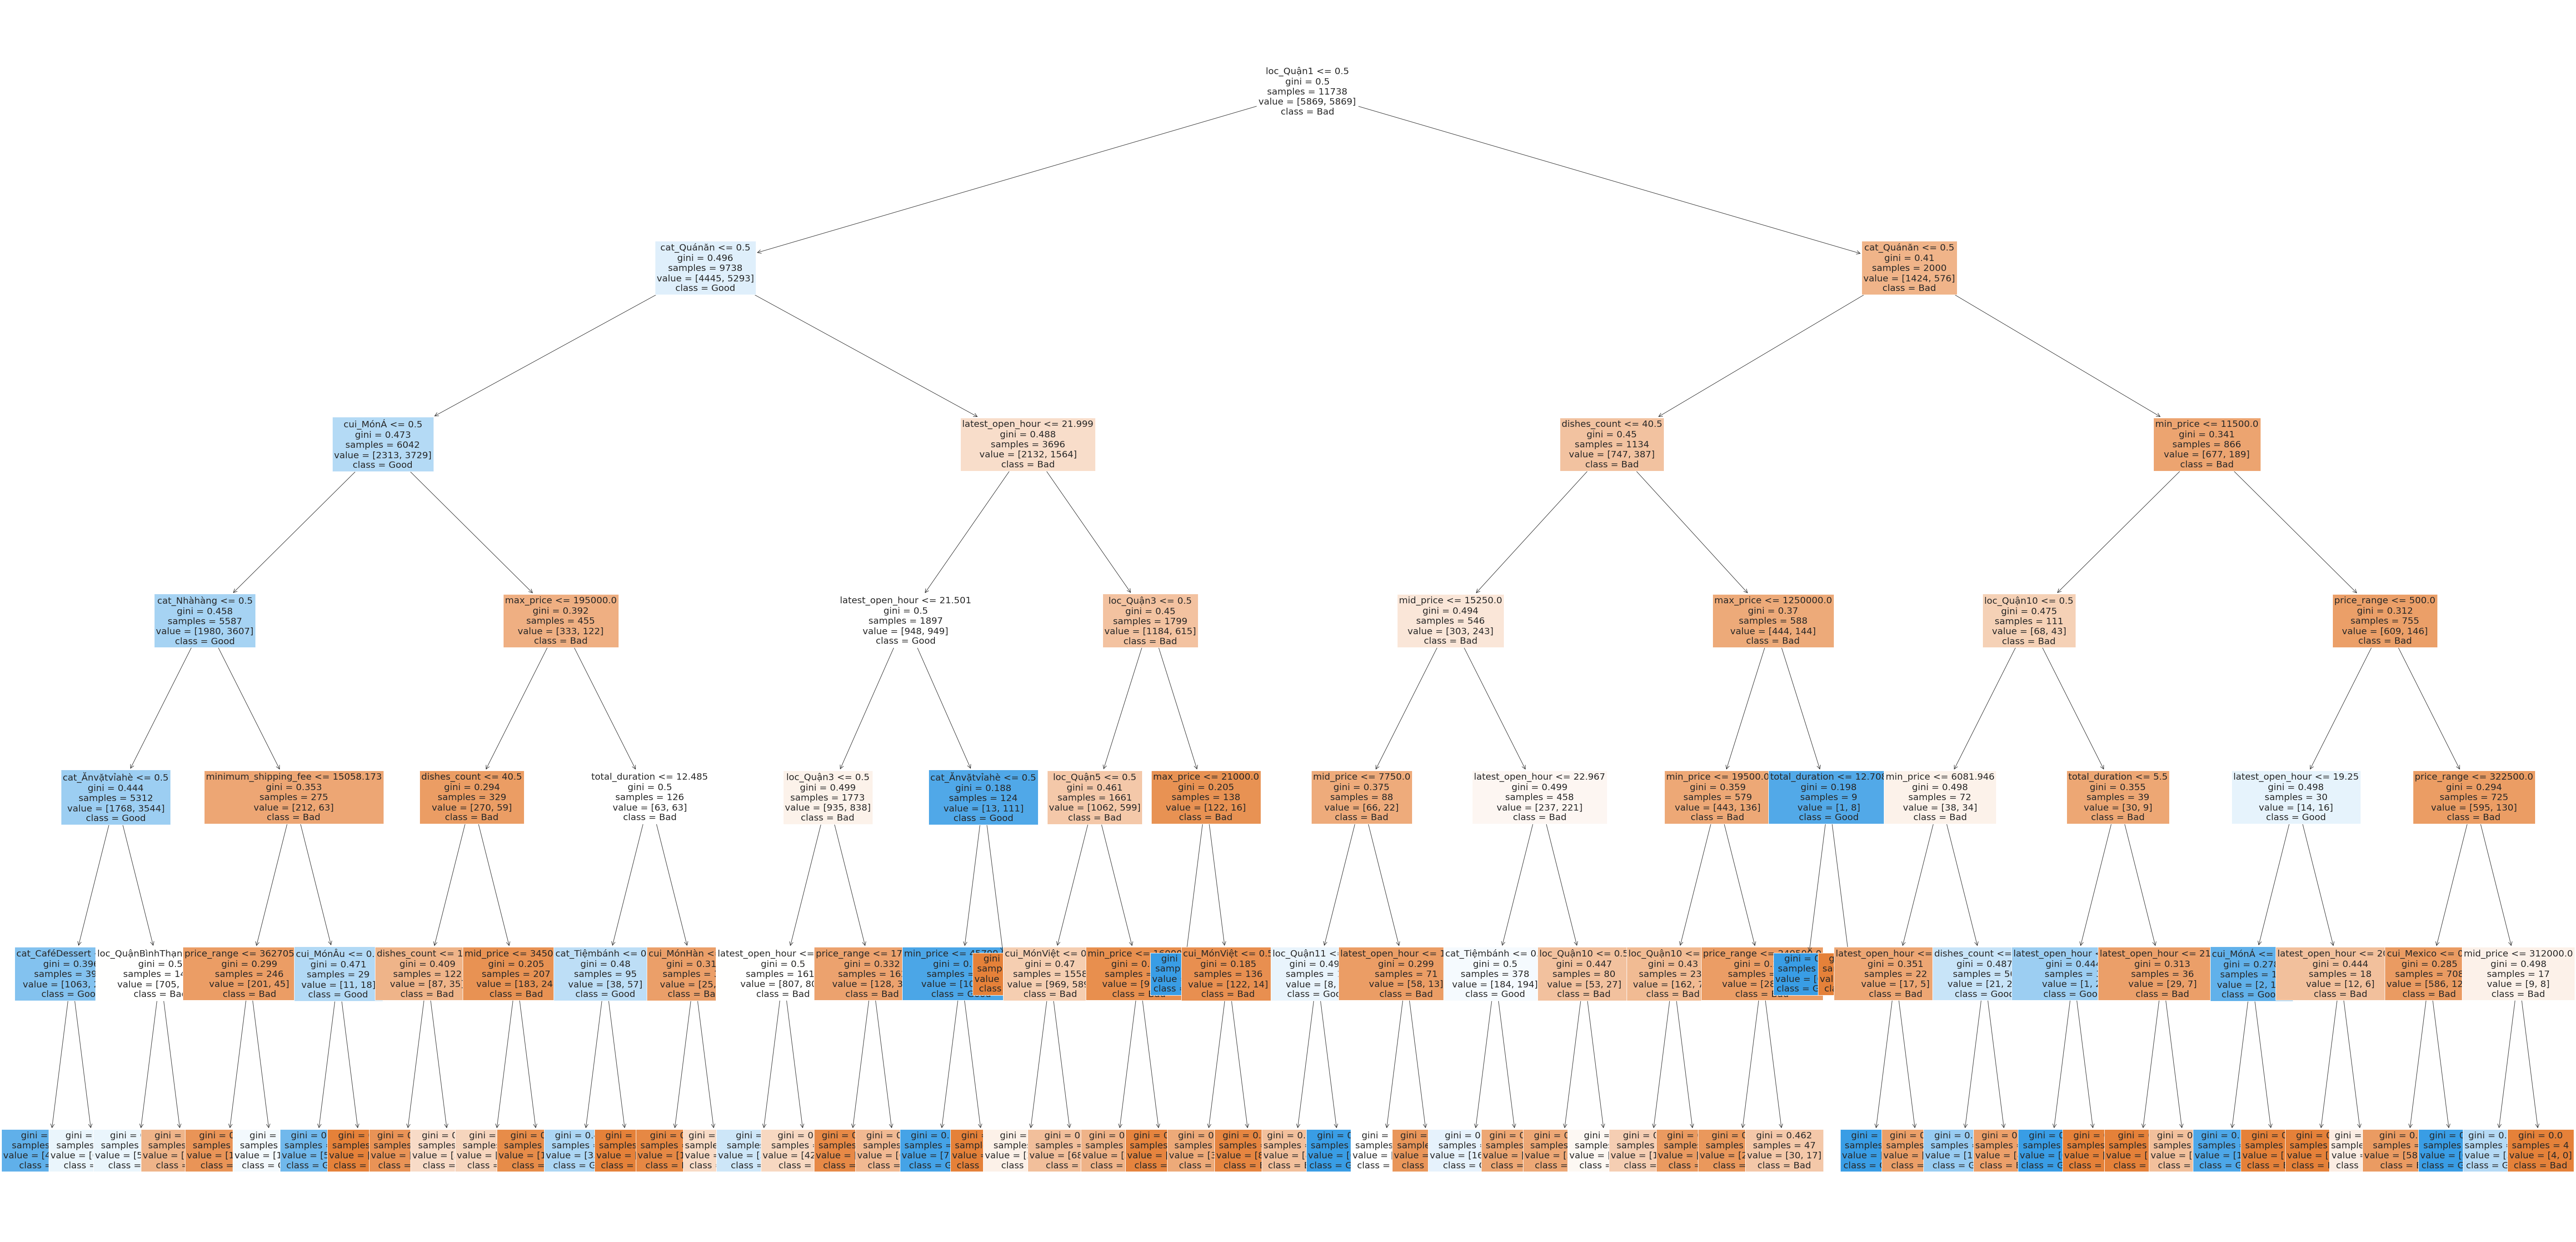

In [ ]:
# Visualize Tree
plt.figure(figsize = (100,50))
tree.plot_tree(
    DTC_model, 
    feature_names = feature_names,
    class_names = label_names,
    fontsize = 20,
    filled = True,
)

### 2. Random Forest

In [ ]:
# Build Random Forest Model
RFC_model = RandomForestClassifier(
  # n_estimators = 100,
  max_depth = MAX_DEPTH_RFC,
)

# Train Random Forest Classifer
RFC_model.fit(X_train,y_train)

#Predict the labels for test dataset
y_pred = RFC_model.predict(X_test)

In [ ]:
# Evaluating Model

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Model Accuracy, how often is the classifier correct?
print("Accuracy (Train):", RFC_model.score(X_train, y_train))
print("Accuracy (Test) :", RFC_model.score(X_test, y_test))
print("Accuracy (Low Reviews Count) :", RFC_model.score(X_low_reviews_count, y_low_reviews_count))

[[1024  485]
 [ 282  268]]
              precision    recall  f1-score   support

         Bad       0.78      0.68      0.73      1509
        Good       0.36      0.49      0.41       550

    accuracy                           0.63      2059
   macro avg       0.57      0.58      0.57      2059
weighted avg       0.67      0.63      0.64      2059

Accuracy (Train): 0.7310444709490543
Accuracy (Test) : 0.6274890723652259
Accuracy (Low Reviews Count) : 0.5978043912175649


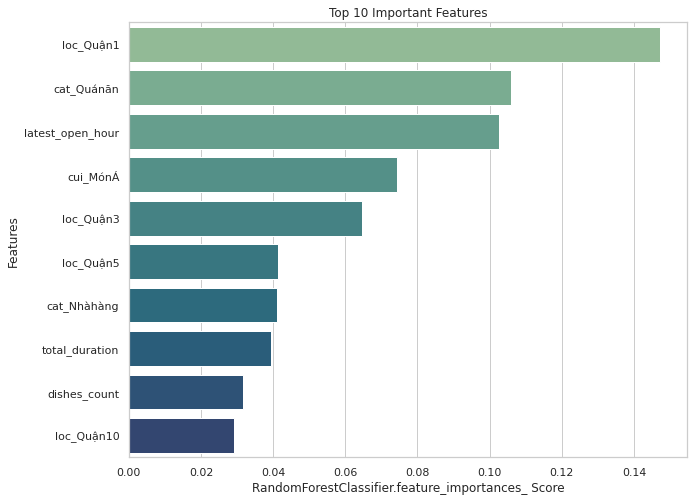

In [ ]:
# Find important features
feature_imp = pd.Series(RFC_model.feature_importances_, index=feature_names).sort_values(ascending=False)
num_feat = 10

plt.figure(figsize = (10,8))
sns.barplot(
  x = feature_imp[:num_feat], 
  y = feature_imp[:num_feat].index,
  palette = 'crest',
)
plt.xlabel('RandomForestClassifier.feature_importances_ Score')
plt.ylabel('Features')
plt.title("Top " + str(num_feat) + " Important Features")
plt.show()

[Text(0.5903716216216216, 0.9285714285714286, 'loc_Quận10 <= 0.5\ngini = 0.5\nsamples = 7369\nvalue = [5915, 5823]\nclass = Bad'),
 Text(0.3547297297297297, 0.7857142857142857, 'loc_Quận3 <= 0.5\ngini = 0.5\nsamples = 6959\nvalue = [5426, 5660]\nclass = Good'),
 Text(0.19932432432432431, 0.6428571428571429, 'loc_Quận7 <= 0.5\ngini = 0.498\nsamples = 6502\nvalue = [4852, 5502]\nclass = Good'),
 Text(0.10810810810810811, 0.5, 'cui_MónÁ <= 0.5\ngini = 0.496\nsamples = 6158\nvalue = [4473, 5326]\nclass = Good'),
 Text(0.05405405405405406, 0.35714285714285715, 'loc_QuậnTânPhú <= 0.5\ngini = 0.49\nsamples = 5700\nvalue = [3906, 5163]\nclass = Good'),
 Text(0.02702702702702703, 0.21428571428571427, 'cat_Quánăn <= 0.5\ngini = 0.487\nsamples = 5433\nvalue = [3621, 5010]\nclass = Good'),
 Text(0.013513513513513514, 0.07142857142857142, 'gini = 0.45\nsamples = 3382\nvalue = [1829, 3523]\nclass = Good'),
 Text(0.04054054054054054, 0.07142857142857142, 'gini = 0.496\nsamples = 2051\nvalue = [1792, 

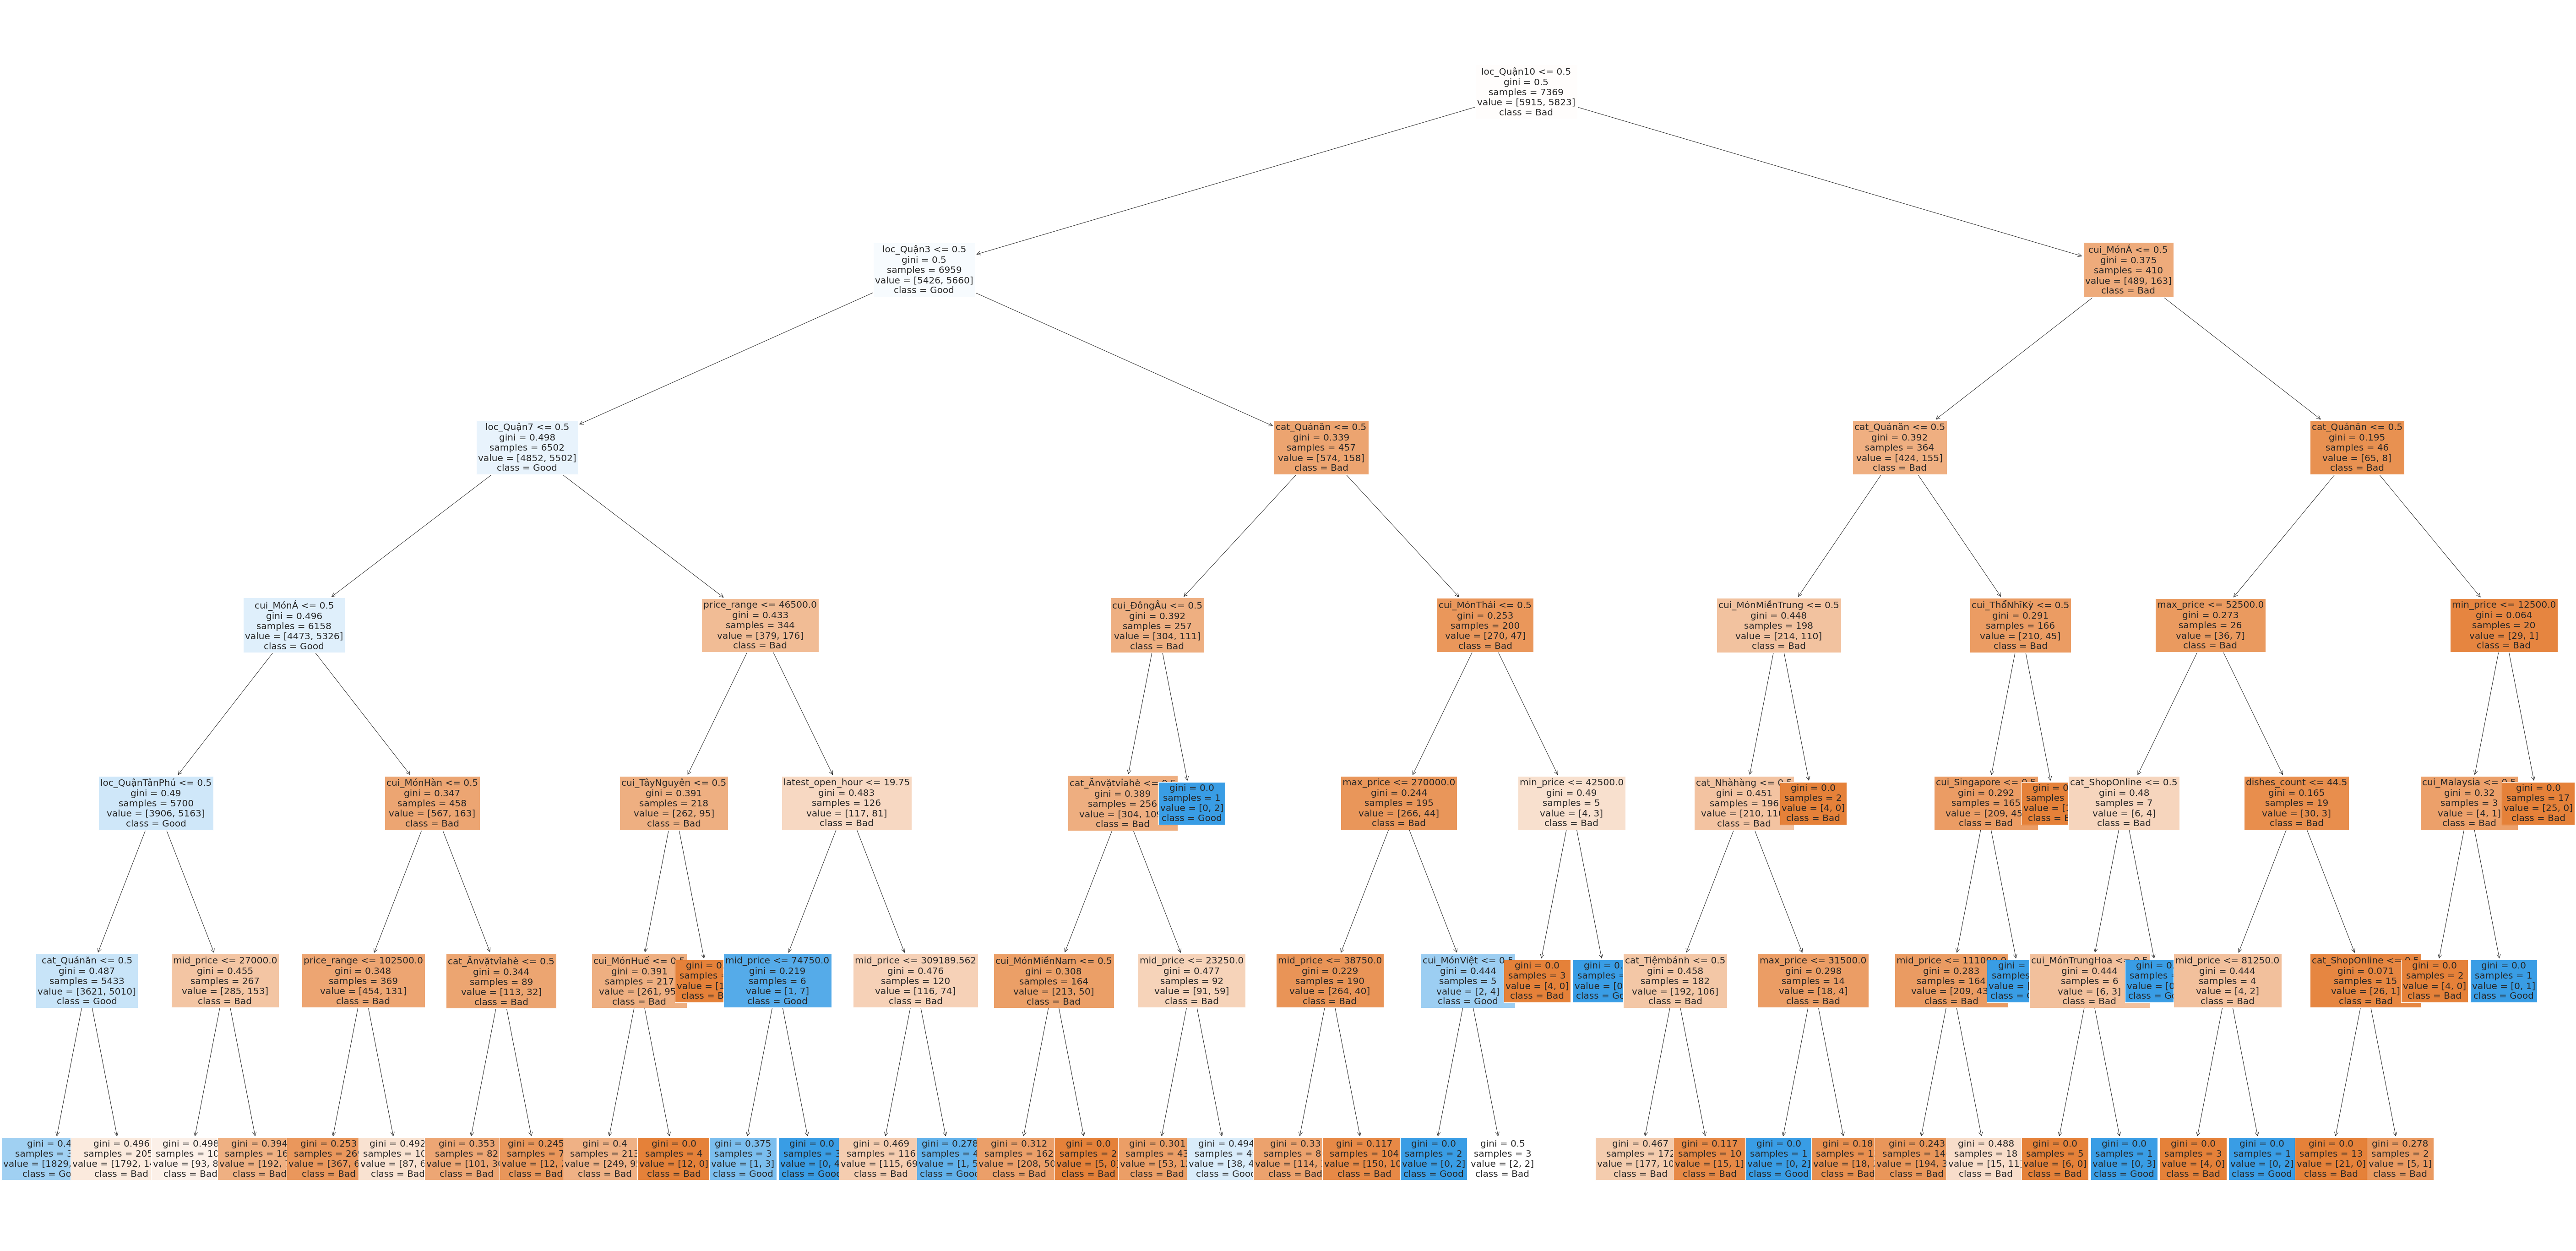

In [ ]:
# Visualize Tree
plt.figure(figsize = (100,50))
tree.plot_tree(
    RFC_model.estimators_[0], 
    feature_names = feature_names,
    class_names = label_names,
    fontsize = 20,
    filled = True,
)

### 3. XGBoost

In [ ]:
# Build XGBoost Model
XGB_model = XGBClassifier(
  max_depth = MAX_DEPTH_XGB,
)

# Train XGBoost Model
XGB_model.fit(X_train, y_train)

#Predict the labels for test dataset
y_pred = XGB_model.predict(X_test)

In [ ]:
# Evaluating Model

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# # Model Accuracy, how often is the classifier correct?
print("Accuracy (Train):", XGB_model.score(X_train, y_train))
print("Accuracy (Test) :", XGB_model.score(X_test, y_test))
print("Accuracy (Low Reviews Count) :", XGB_model.score(X_low_reviews_count, y_low_reviews_count))

[[1316  193]
 [ 408  142]]
              precision    recall  f1-score   support

         Bad       0.76      0.87      0.81      1509
        Good       0.42      0.26      0.32       550

    accuracy                           0.71      2059
   macro avg       0.59      0.57      0.57      2059
weighted avg       0.67      0.71      0.68      2059

Accuracy (Train): 0.849122508093372
Accuracy (Test) : 0.7081107333657115
Accuracy (Low Reviews Count) : 0.6057884231536926


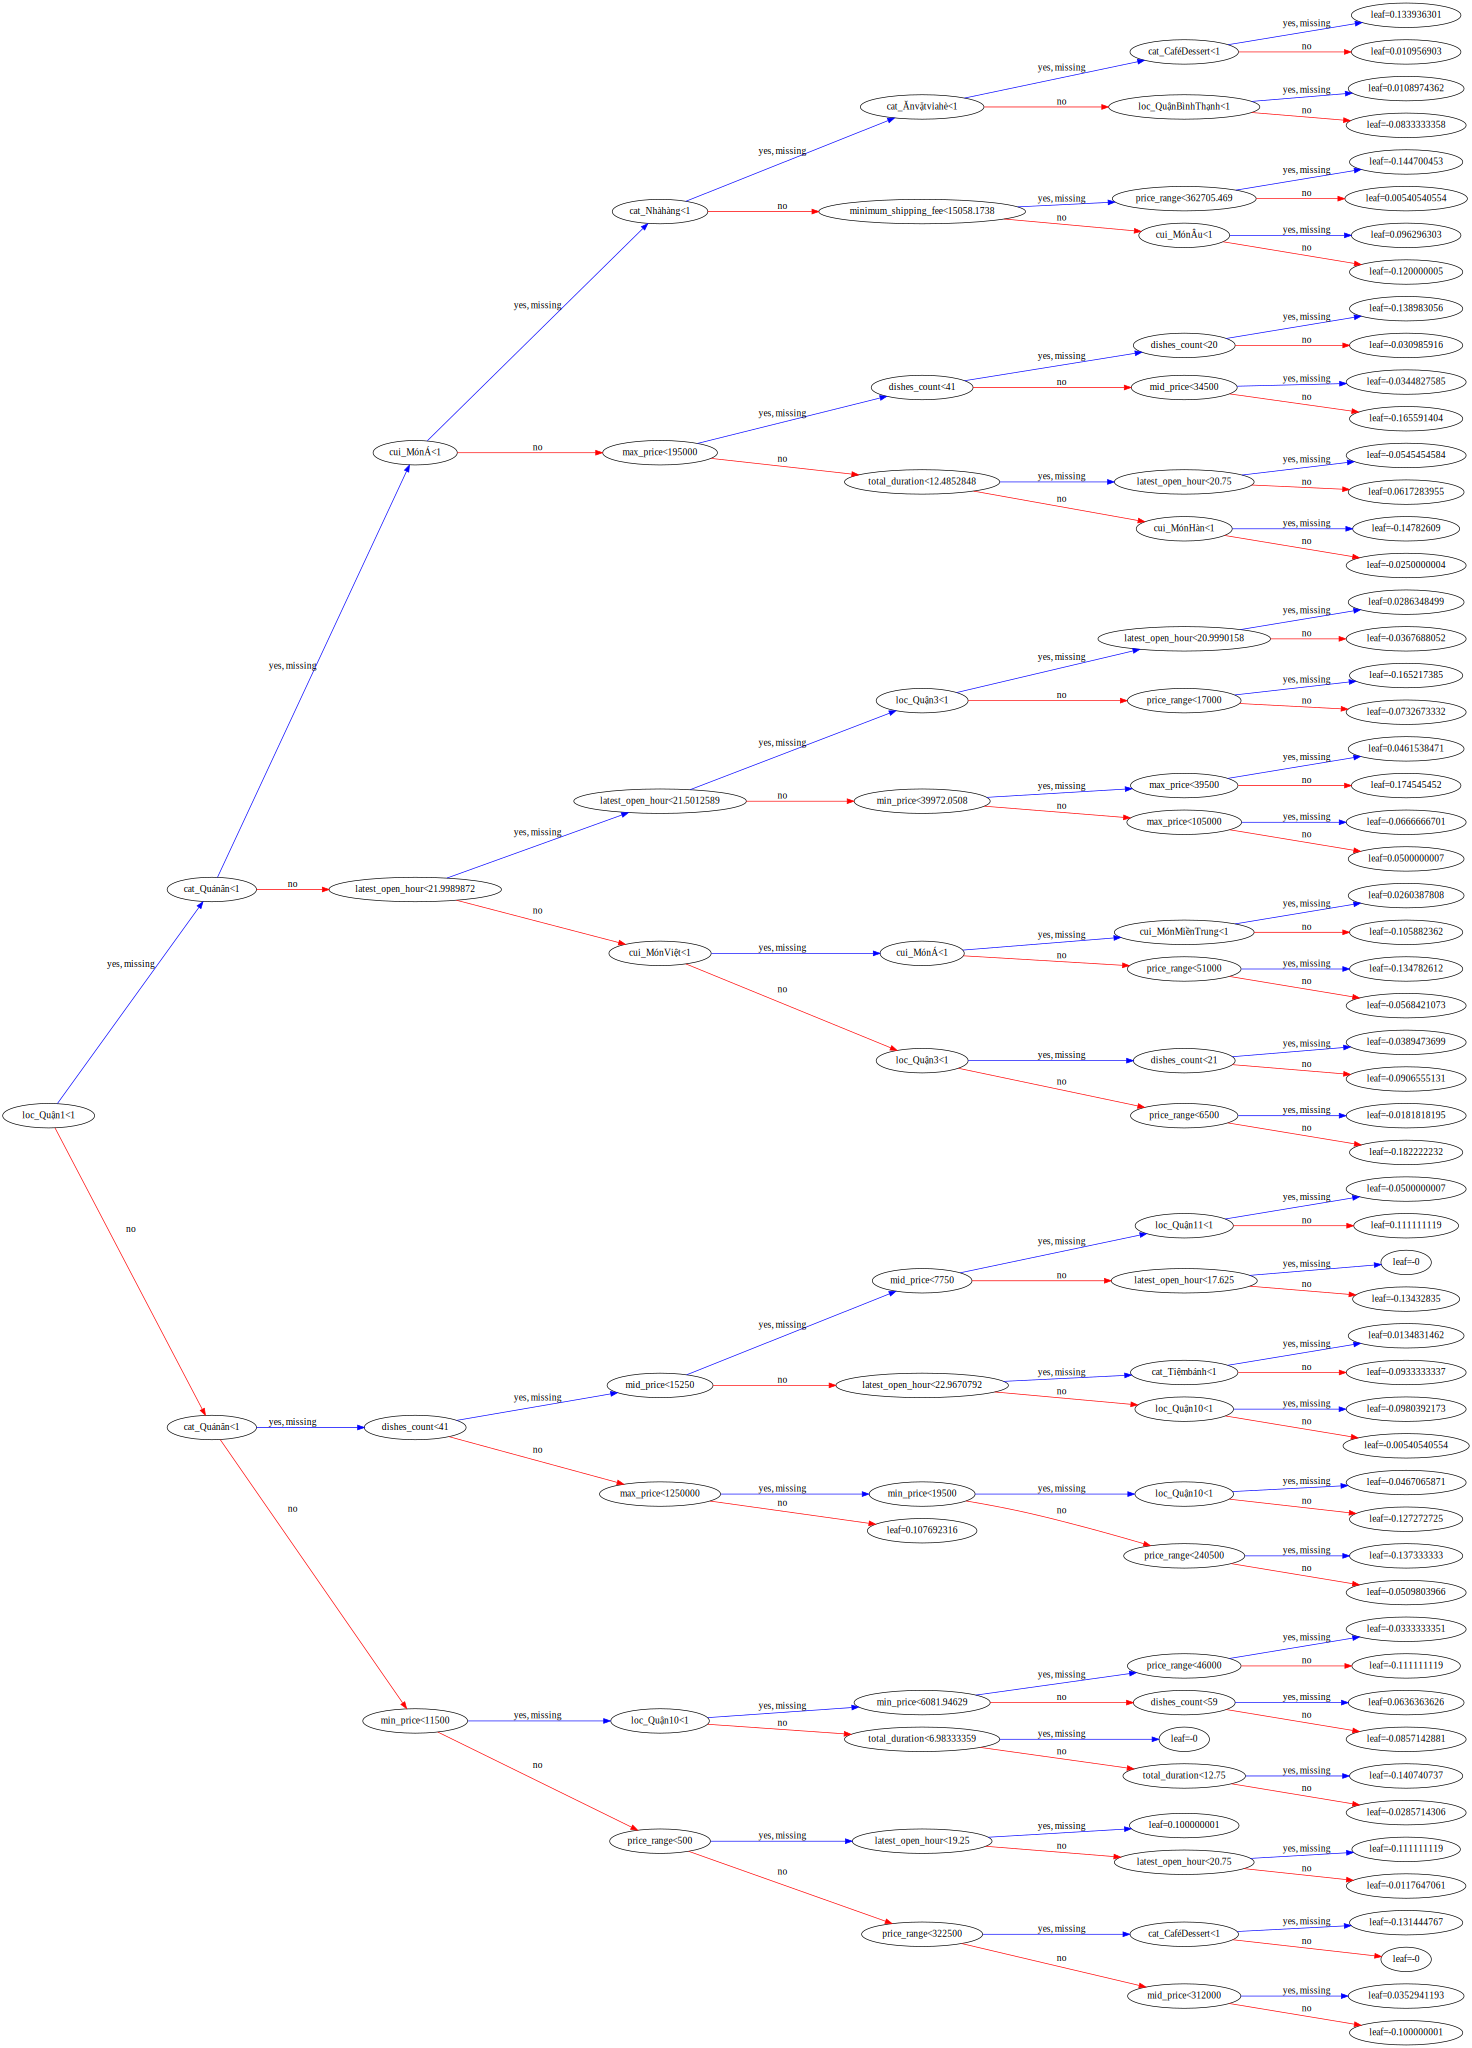

In [ ]:
# Visualize
xgboost.to_graphviz(XGB_model, rankdir='LR')

# IV. Conclusion

**Proposal Question**: "Do factors such as price, working time, location, menu,... affect the success of a restaurant in the Ho Chi Minh City area?"

**Answer**: No. Those factors have ***no/very little effect*** on the success of a restaurant.

**Why**:

* The models are prone to be easily overfitted. We tracked the performance of all models when tuning the hyperparameters and realized that: the `train accuracy score` can be really high, but the `test accuracy score` keeps fluctuating around a constant not-high number (0.6 - 0.7).
* The `F1-score` (and `precision`, `recall`) of the label "Good" (minority class) is very low. We tested some sampling method to balance the dataset and track the performance of models: `F1-score` increased (not much), but this is a trade-off, because the `accuracy score` (not high already) decreased. (Every test that we try to balance the dataset will lead to this trade-off)

**The trade-off**:

* An unbalanced classification model has high `accuracy score` (around 0.8), but low `F1-score` (around 0.2) means that: it only need to predict all the samples as the majority class (in this situation, the "Bad" label), and it will have high accuracy.
* A re-balanced classification model (with sampling data) has not-high `accuracy score` (around 0.6) and not-high `F1-score` (around 0.5) is still bad. 0.6 accuracy (near 0.5) is too similar to take the result of tossing a coin.

# V. Extra testing

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

LR_model = LogisticRegression()
LR_model.fit(X_train, y_train)
y_pred = LR_model.predict(X_test)

# Evaluating Model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Model Accuracy, how often is the classifier correct?
print("Accuracy (Train):", LR_model.score(X_train, y_train))
print("Accuracy (Test) :", LR_model.score(X_test, y_test))
print("Accuracy (Low Reviews Count) :", LR_model.score(X_low_reviews_count, y_low_reviews_count))

[[659 850]
 [179 371]]
              precision    recall  f1-score   support

         Bad       0.79      0.44      0.56      1509
        Good       0.30      0.67      0.42       550

    accuracy                           0.50      2059
   macro avg       0.55      0.56      0.49      2059
weighted avg       0.66      0.50      0.52      2059

Accuracy (Train): 0.5598057590730959
Accuracy (Test) : 0.5002428363283147
Accuracy (Low Reviews Count) : 0.5089820359281437


### SVM

In [ ]:
from sklearn import svm

SVM_model = svm.SVC()
SVM_model.fit(X_train, y_train)
y_pred = SVM_model.predict(X_test)

# Evaluating Model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Model Accuracy, how often is the classifier correct?
print("Accuracy (Train):", SVM_model.score(X_train, y_train))
print("Accuracy (Test) :", SVM_model.score(X_test, y_test))
print("Accuracy (Low Reviews Count) :", SVM_model.score(X_low_reviews_count, y_low_reviews_count))

[[557 952]
 [151 399]]
              precision    recall  f1-score   support

         Bad       0.79      0.37      0.50      1509
        Good       0.30      0.73      0.42       550

    accuracy                           0.46      2059
   macro avg       0.54      0.55      0.46      2059
weighted avg       0.66      0.46      0.48      2059

Accuracy (Train): 0.5405520531606748
Accuracy (Test) : 0.4643030597377368
Accuracy (Low Reviews Count) : 0.49750499001996007


### Gaussian Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

GNB_model = GaussianNB()
GNB_model.fit(X_train, y_train)
y_pred = GNB_model.predict(X_test)

# Evaluating Model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Model Accuracy, how often is the classifier correct?
print("Accuracy (Train):", GNB_model.score(X_train, y_train))
print("Accuracy (Test) :", GNB_model.score(X_test, y_test))
print("Accuracy (Low Reviews Count) :", GNB_model.score(X_low_reviews_count, y_low_reviews_count))

[[1430   79]
 [ 512   38]]
              precision    recall  f1-score   support

         Bad       0.74      0.95      0.83      1509
        Good       0.32      0.07      0.11       550

    accuracy                           0.71      2059
   macro avg       0.53      0.51      0.47      2059
weighted avg       0.63      0.71      0.64      2059

Accuracy (Train): 0.5092008860112456
Accuracy (Test) : 0.7129674599320058
Accuracy (Low Reviews Count) : 0.5588822355289421


### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

KNC_model = KNeighborsClassifier(
  n_neighbors = 2,
)
KNC_model.fit(X_train, y_train)
y_pred = KNC_model.predict(X_test)

# Evaluating Model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Model Accuracy, how often is the classifier correct?
print("Accuracy (Train):", KNC_model.score(X_train, y_train))
print("Accuracy (Test) :", KNC_model.score(X_test, y_test))
print("Accuracy (Low Reviews Count) :", KNC_model.score(X_low_reviews_count, y_low_reviews_count))

[[1189  320]
 [ 405  145]]
              precision    recall  f1-score   support

         Bad       0.75      0.79      0.77      1509
        Good       0.31      0.26      0.29       550

    accuracy                           0.65      2059
   macro avg       0.53      0.53      0.53      2059
weighted avg       0.63      0.65      0.64      2059

Accuracy (Train): 0.9127619696711535
Accuracy (Test) : 0.647887323943662
Accuracy (Low Reviews Count) : 0.5523952095808383


# VI. After Presentation

Find samples that have many same features but not the same label -> it's hard to build a model for classification.

In [ ]:
X = df_3.drop('Label', axis=1)
y = df_3['Label']

feature_names = list(X.columns)
print(feature_names)

label_names = list(y.unique())
print(label_names)

['min_price', 'max_price', 'minimum_shipping_fee', 'price_range', 'mid_price', 'dishes_count', 'earliest_open_hour', 'latest_open_hour', 'total_duration', 'cat_Nhàhàng', 'cat_Ănvặtvỉahè', 'cat_Quánăn', 'cat_Tiệmbánh', 'cat_Buffet', 'cat_Beerclub', 'cat_ShopCửahàng', 'cat_CaféDessert', 'cat_Sangtrọng', 'cat_Giaocơmvănphòng', 'cat_Ănchay', 'cat_ShopOnline', 'cat_Quánnhậu', 'cat_BarPub', 'cat_Chợ', 'cat_KhuẨmThực', 'cat_MuasắmOnline', 'cat_Rạpchiếuphim', 'cat_Tiệctậnnơi', 'cat_Siêuthị', 'cat_Hoacưới-Shophoa', 'cat_TiệccướiHộinghị', 'cat_Vậtnuôi', 'cat_Nhàthuốc', 'cat_Trungtâmthươngmại', 'cat_Shophóamỹphẩm', 'cat_Billiards', 'cat_KhuchơiGame', 'cat_SpaMassage', 'cat_Thămquan&chụpảnh', 'cat_Kháchsạn', 'cui_MónÂu', 'cui_MónThái', 'cui_MónÁ', 'cui_MónMiềnNam', 'cui_MónTrungHoa', 'cui_MónMiềnTrung', 'cui_NhaTrang', 'cui_MónNhật', 'cui_ĐàiLoan', 'cui_ChâuMỹ', 'cui_Mỹ', 'cui_Quốctế', 'cui_Ý', 'cui_MónBắc', 'cui_HàNội', 'cui_MónViệt', 'cui_Đặcsảnvùng', 'cui_Philippines', 'cui_MónHàn', 'cui_MónHuế

In [ ]:
from sklearn.neighbors import NearestNeighbors
NN_model = NearestNeighbors(
  n_neighbors = 2, 
  algorithm = 'auto'
)
NN_model.fit(X)
NN_distances, NN_indices = NN_model.kneighbors(X)
print(NN_indices)
print(NN_distances)

[[    0  3395]
 [    1  8024]
 [    2  9421]
 ...
 [10292   426]
 [10293  3832]
 [10294 10265]]
[[ 0.          2.        ]
 [ 0.         34.64512553]
 [ 0.          2.64575131]
 ...
 [ 0.          4.60977223]
 [ 0.          7.77817459]
 [ 0.          4.37321392]]


In [ ]:
idx = 0

for i in range(10000):
  nn = df_3.iloc[[
    NN_indices[i][0],
    NN_indices[i][1],
  ]]
  if len(nn['Label'].unique()) == 2:
    if NN_distances[i][1] < 2.0:
      idx = i
      break

print(NN_distances[idx])

nn

[0. 1.]


min_price  max_price  minimum_shipping_fee  price_range  mid_price  \
61367    30000.0   100000.0               15000.0      70000.0    65000.0   
61368    30000.0   100000.0               15000.0      70000.0    65000.0   

       dishes_count  earliest_open_hour  latest_open_hour  total_duration  \
61367            36                -1.0              23.0            16.5   
61368            35                -1.0              23.0            16.5   

      Label  ...  loc_Quận8  loc_Quận4  loc_QuậnBìnhThạnh  loc_Quận6  \
61367  Good  ...          0          0                  0          0   
61368   Bad  ...          0          0                  0          0   

       loc_Quận11  loc_HuyệnBìnhChánh  loc_Quận2  loc_HuyệnNhàBè  \
61367           0                   0          0               0   
61368           0                   0          0               0   

       loc_HuyệnHócMôn  loc_HuyệnCủChi  
61367                0               0  
61368                0               0  

[2 rows x 113 columns]

In [ ]:
df.loc[[
  61367,
  61368,
]][[
  'Name_Res',
  'address',
  'Average Rating',
]]

Name_Res  \
61367  Katinat Saigon Kafe - An Dương Vương   
61368   Katinat Saigon Kafe - Trần Hưng Đạo   

                                         address  Average Rating  
61367     1 An Dương Vương, P.8, Quận 5, TP. HCM            8.00  
61368  400A Trần Hưng Đạo, P.11, Quận 5, TP. HCM            4.28

In [ ]:
print(df.loc[[
  61367,
  61368,
]])

                                   Name_Res                   Categories  \
61367  Katinat Saigon Kafe - An Dương Vương  ['Café/Dessert', 'Quán ăn']   
61368   Katinat Saigon Kafe - Trần Hưng Đạo  ['Café/Dessert', 'Quán ăn']   

      Cuisines  total_review_shopee_food  has_contract  avg_point  \
61367      NaN                    1000.0             1        4.9   
61368      NaN                    1000.0             1        4.8   

                                         address  min_price  max_price  \
61367     1 An Dương Vương, P.8, Quận 5, TP. HCM    30000.0   100000.0   
61368  400A Trần Hưng Đạo, P.11, Quận 5, TP. HCM    30000.0   100000.0   

       minimum_shipping_fee  ...  duration_1  duration_2  duration_3  \
61367               15000.0  ...        16.5         0.0         0.0   
61368               15000.0  ...        16.5         0.0         0.0   

       total_duration  earliest_open_hour latest_open_hour mid_price  \
61367            16.5                -1.0          